# 0.0 Imports

## 0.1 Libraries

In [197]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import datetime
import warnings
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer
from category_encoders import TargetEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from skopt import BayesSearchCV
# import pickle
# from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 0.2 Data

In [3]:
dados_sales = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/train.csv',low_memory=False)
dados_stores = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/store.csv')
dados = pd.merge(dados_sales,dados_stores,how='left',on='Store')
dados = dados.sample(int(round(dados.shape[0]/2,0)),random_state=101) # more data this time
dados.reset_index(drop=True,inplace=True)
dados.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,965,7,2014-11-02,0,0,0,0,0,0,a,c,110.0,NaN,NaN,0,NaN,NaN,NaN
1,268,1,2013-12-30,6995,814,1,0,0,1,a,a,4520.0,2.0,2014.0,0,NaN,NaN,NaN
2,1112,6,2015-03-28,8671,774,1,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
3,128,1,2014-07-21,6675,534,1,0,0,0,d,c,2000.0,NaN,NaN,1,1.0,2013.0,"Jan,Apr,Jul,Oct"
4,687,4,2015-06-11,6961,675,1,0,0,0,d,c,2770.0,NaN,NaN,0,NaN,NaN,NaN


## Export Data

In [4]:
dados.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/inital_data2.csv',index=False)

# 1.0 Data Description and Cleaning

## Import Data

In [132]:
dados = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/inital_data2.csv')

## 1.1 Rename Columns and Values

In [117]:
# CamelCase to snake_case
for c in range(len(dados.columns)):
    dados.rename(columns={dados.columns.values[c]:inflection.underscore(dados.columns.values[c])},inplace=True)

In [33]:
dados['state_holiday'] = dados['state_holiday'].map({'a':'public holiday', 'b':'Easter holiday', 'c':'Christmas', '0':'None'})
dados['assortment'] = dados['assortment'].map({'a':'basic','b':'extra','c':'extended'})

## 1.2 Data Dimension

In [34]:
print(f'Rows: {dados.shape[0]}\nColumns: {dados.shape[1]}')

Rows: 508604
Columns: 18


## 1.3 Missing Data

### 1.3.1 Check

In [36]:
dados.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              1340
competition_open_since_month    161737
competition_open_since_year     161737
promo2                               0
promo2_since_week               254124
promo2_since_year               254124
promo_interval                  254124
dtype: int64

### 1.3.2 Handling with

In [37]:
# I suppose that the competition_distance == nan refers that there's no competition!
# Lets'se if it's true

dados[dados['competition_distance'].isna()].isna().sum()

store                              0
day_of_week                        0
date                               0
sales                              0
customers                          0
open                               0
promo                              0
state_holiday                      0
school_holiday                     0
store_type                         0
assortment                         0
competition_distance            1340
competition_open_since_month    1340
competition_open_since_year     1340
promo2                             0
promo2_since_week                937
promo2_since_year                937
promo_interval                   937
dtype: int64

Yeah, thats true, this data probably is missing at random (MAR), then we can input it with some arbitrary value.

All of the empty distances have empty competition_open_since.. what confirm that the competition has never been started! 

In [38]:
# Vou usar um valor arbitrário que significará que a competição nunca abriu!

for index in dados[dados['competition_distance'].isna()].index:
    dados.loc[index,'competition_distance'] = 999999 # High values suggests that the competitors are so far that there's no competition
    dados.loc[index,'competition_open_since_month'] = -1 # It suggets that it has never been opened
    dados.loc[index,'competition_open_since_year'] = -1 # It suggets that it has never been opened

In [39]:
# Ver quantos restaram
dados.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    160397
competition_open_since_year     160397
promo2                               0
promo2_since_week               254124
promo2_since_year               254124
promo_interval                  254124
dtype: int64

In [40]:
# I suppose that if there's no year since competition started, there's no month and vice-versa (there's no date record)
# Let's se if it's true

dados[dados['competition_open_since_month'].isna()].isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    160397
competition_open_since_year     160397
promo2                               0
promo2_since_week                68367
promo2_since_year                68367
promo_interval                   68367
dtype: int64

Era isso mesmo!

In [41]:
# Vamos ver se a loja que tem competition date nulo em um record tem, em outro record, competition date não nulo
# caso a intersecção seja vazia, significa que a todos os records dessas lojas sem competition date são nulos
# isso pode nos indicar que essas lojas provavelmente não documentaram desde quando começou a competition

lojas_com_competition_date = dados[~dados['competition_open_since_month'].isna()]['store'].unique()
lojas_sem_competition_date = dados[dados['competition_open_since_month'].isna()]['store'].unique()

np.intersect1d(lojas_com_competition_date,lojas_sem_competition_date)

array([], dtype=int64)

Realmente era o que eu estava pensando, dessa forma, as competition dates não foram documentadas por algum motivo: seja por nunca informaram à base de dados, ou não conseguiram chegar à data, ou a loja foi implementada depois do concorrente, em problema real seria interessante tentar entender afundo o motivo disso, pois assim poderíamos diagnosticar o tipo de missing data e escolher a técnica mais efetiva para solucionar o problema!

In [42]:
# Dessa forma, o tipo de missing data é de difícil diagnóstico, e para não perder muitos records
# vou imputar um valor arbitrário também!

for index in dados[dados['competition_open_since_month'].isna()].index:
    dados.loc[index,'competition_open_since_month'] = 999999 
    dados.loc[index,'competition_open_since_year'] = 999999 

In [44]:
# Ver quantos restaram
dados.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               254124
promo2_since_year               254124
promo_interval                  254124
dtype: int64

In [45]:
# I wanna check if the NaN in these columns are just when promo2 is 0 (no promo2) what would be very logic.
# Because if there's no promo2, theres no since date or interval

(dados[dados['promo2']==0].isna()).sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               254124
promo2_since_year               254124
promo_interval                  254124
dtype: int64

So true! 

Every NaN in the last 3 columns is because promo2 has never been started!

In [46]:
for index in dados[dados['promo2_since_week'].isna()].index:
    dados.loc[index, 'promo2_since_week'] = -1 # It suggets that there's no promo2 start
    dados.loc[index, 'promo2_since_year'] = -1 # It suggets that there's no promo2 start
    dados.loc[index, 'promo_interval'] = 'No promo2' # It suggets that there's no promo2 start

### 1.3.3 Final Check

In [48]:
dados.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

All done.

## 1.4 Data Types

### 1.4.1 Check

In [49]:
dados.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

### 1.4.2 Change

In [50]:
# date to datetime64 and int to float
dados['date'] = pd.to_datetime(dados['date'])
dados['competition_open_since_month'] = dados['competition_open_since_month'].astype(int)
dados['competition_open_since_year'] = dados['competition_open_since_year'].astype(int)
dados['promo2_since_week'] = dados['promo2_since_week'].astype(int)
dados['promo2_since_year'] = dados['promo2_since_year'].astype(int)

### 1.4.3 Final Check

In [51]:
dados.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

All done.

## 1.5 Descriptive Statistics

### 1.5.1 Numeric Variables Analysis

In [61]:
df_aux = dados[['store','sales','customers','competition_distance','competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year']]

num_kurt = df_aux.apply(lambda x: x.kurtosis()) # Add kurtosis
num_skewness = df_aux.apply(lambda x: x.skew()) # Add skewness
num_range = df_aux.apply(lambda x: x.max() - x.min()) # Add range
pd.concat([df_aux.describe().T,num_kurt,num_skewness,num_range],axis=1).rename(columns={0:'kurtosis',1:'skewness',2:'range'}).drop('count',1)

,mean,std,min,25%,50%,75%,max,kurtosis,skewness,range
store,558.521199,321.876947,1.0,280.0,558.0,837.0,1115.0,-1.199360,-0.001800,1114.0
sales,5772.169863,3855.057633,0.0,3724.0,5740.0,7852.0,41551.0,1.846384,0.653961,41551.0
customers,632.951320,465.456060,0.0,404.0,609.0,836.0,5494.0,7.152674,1.615475,5494.0
competition_distance,8049.123542,51560.743037,20.0,710.0,2330.0,6910.0,999999.0,357.928221,18.766489,999979.0
competition_open_since_month,315371.770515,464658.586555,-1.0,6.0,10.0,999999.0,999999.0,-1.368458,0.794700,1000000.0
competition_open_since_year,316736.770432,463732.168400,-1.0,2008.0,2012.0,999999.0,999999.0,-1.368458,0.794700,1000000.0
promo2_since_week,11.152162,15.714188,-1.0,-1.0,1.0,22.0,50.0,-0.557693,0.970053,51.0
promo2_since_year,1006.077951,1006.374965,-1.0,-1.0,2009.0,2012.0,2015.0,-2.000000,-0.001396,2016.0


Nothing strange.

The only strange values that we see were the ones that we chose arbitraly to substitute.

### 1.5.2 Categorical Variables Analysis

In [64]:
df_aux = dados.drop(['store','sales','customers','competition_distance','competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year','date'],1)

for column in df_aux:
    print(column.upper()+':')
    print(round(df_aux[column].value_counts(normalize=True)*100,2))
    print('')

DAY_OF_WEEK:
4    14.35
2    14.32
3    14.30
6    14.28
5    14.27
7    14.26
1    14.22
Name: day_of_week, dtype: float64

OPEN:
1    82.99
0    17.01
Name: open, dtype: float64

PROMO:
0    61.86
1    38.14
Name: promo, dtype: float64

STATE_HOLIDAY:
None              96.98
public holiday     1.97
Easter holiday     0.65
Christmas          0.41
Name: state_holiday, dtype: float64

SCHOOL_HOLIDAY:
0    82.18
1    17.82
Name: school_holiday, dtype: float64

STORE_TYPE:
a    54.22
d    30.78
c    13.43
b     1.57
Name: store_type, dtype: float64

ASSORTMENT:
basic       52.79
extended    46.38
extra        0.83
Name: assortment, dtype: float64

PROMO2:
1    50.03
0    49.97
Name: promo2, dtype: float64

PROMO_INTERVAL:
No promo2           49.97
Jan,Apr,Jul,Oct     28.83
Feb,May,Aug,Nov     11.65
Mar,Jun,Sept,Dec     9.56
Name: promo_interval, dtype: float64



Everything looks nice. Nothing strange or considerable outliers.

## 1.6 Columns and Values Filtering

In [118]:
# Let's filter what is useful and useless for our prediction based on the business problem

dados = dados[dados['open']==1] # We want to predict sales when the store is open. When it's closed, sales == 0
dados.drop('open',axis=1,inplace=True) # This column would be constant == 1, useless for our prediction

In [ ]:
# I also need to drop customers, because i cant say how many customers i will have in the store tomorrow
# I would need to make another model to predict it, so i cannot use this column as an input

# Apesar disso, a gente pode usar essa coluna 'customers' para retirar alguns insights legais ou algo a mais!
# Então vou fazer feature engineering com essa coluna, usar na EDA e depois dropar!

## Exporting Dataset (After Data Cleaning)

In [127]:
dados.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_cleaned2.csv',index=False)

# 2.0 Feature Engineering and Exploratory Data Analysis

## Import Data

In [154]:
dados = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_cleaned2.csv')

## 2.1 Feature Engineering

Ao invés de ir criando features ao longo da EDA, prefiro criar esse tópico onde coloco todas elas juntas!

Mantendo, assim, o código organizado e limpo!

In [24]:
# Day, Month, Week and Year Variables
dados['day'] = pd.to_datetime(dados['date']).dt.day
dados['month'] = pd.to_datetime(dados['date']).dt.month
dados['year'] = pd.to_datetime(dados['date']).dt.year
dados['week'] = pd.to_datetime(dados['date']).dt.week

In [25]:
# Semester and Quarter
dados['quarter'] = pd.to_datetime(dados['date']).dt.quarter
dados['semester'] = pd.to_datetime(dados['date']).dt.quarter.apply(lambda x: 1 if x == 1 or x == 2 else 2)

In [26]:
# Season
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

dados['season'] = pd.to_datetime(dados['date']).map(season_of_date)

In [27]:
# Weeks for timeseries analyses
dados['week_bin'] = np.nan
for index in range(dados.shape[0]):
    if dados.loc[index,'year']==2013:
        dados.loc[index,'week_bin'] = dados.loc[index,'week']
    if dados.loc[index,'year']==2014:
        dados.loc[index,'week_bin'] = dados.loc[index,'week'] + 52
    if dados.loc[index,'year']==2015:
        dados.loc[index,'week_bin'] = dados.loc[index,'week'] + 104
dados['week_bin'] = dados['week_bin'].astype('int')

In [28]:
# Competition Lifetime
dados['competition_lifetime'] = np.nan
for index in range(dados.shape[0]):
    try:
        data = datetime.datetime(dados.loc[index,'competition_open_since_year'],dados.loc[index,'competition_open_since_month'],1)
        dados.loc[index, 'competition_lifetime'] = (pd.to_datetime(dados.loc[index,'date']) - data).days
        
    except:
        dados.loc[index,'competition_lifetime'] = -999 # Never opened
dados['competition_lifetime'] = dados['competition_lifetime'].astype('int')

In [29]:
# Competition
dados['competition'] = dados['competition_lifetime'].apply(lambda x: 0 if x<0 else 1) 

# Negative values suggests that this competition has never been started yet or we don't even have competitors (we chose -999 above)

In [30]:
# Promo2 Lifetime
dados['promo2_lifetime'] = np.nan
for index in range(dados.shape[0]):
    if dados.loc[index,'promo_interval'] != 'No promo2':
        year = dados.loc[index,'promo2_since_year']
        week = dados.loc[index,'promo2_since_week']
        date = "{}-W{}".format(year,week)
        date_datetime = datetime.datetime.strptime(date + '-1', "%Y-W%W-%w")
        dados.loc[index,'promo2_lifetime'] = (pd.to_datetime(dados.loc[index,'date']) - date_datetime).days
    else:
        dados.loc[index,'promo2_lifetime'] = -999
dados['promo2_lifetime'] = dados['promo2_lifetime'].astype(int)

In [31]:
# Promo Count per Week
dados['promo_count_per_week'] = np.nan
for index in range(dados.shape[0]):
    week = dados.loc[index,'week_bin']
    store = dados.loc[index,'store']
    try:
        dados.loc[index,'promo_count_per_week'] = dados[dados['store']==store].groupby('week_bin').sum()['promo'][week]
    except:
        dados.loc[index,'promo_count_per_week'] = 0
dados['promo_count_per_week'] = dados['promo_count_per_week'].astype('int')

In [32]:
# Enumerate per week each store promotion
dados['promo_n'] = np.nan
for c in range(dados.shape[0]):
    if dados.loc[c,'promo_count_per_week']>0: # os que tem promoção na semana: Enumerate the promotion per store on each week
        week = dados.loc[c,'week_bin']
        store = dados.loc[c,'store']
        df_aux = pd.DataFrame(dados[(dados['store']==store)&(dados['week_bin']==week)].sort_values(by='date')['promo'])[dados['promo']==1].reset_index().reset_index().set_index('index')
        df_aux['level_0'] = df_aux['level_0'] + 1
        for index in df_aux.index:
            dados.loc[index,'promo_n'] = df_aux.loc[index,'level_0']
    elif dados.loc[c,'promo_count_per_week']==0: # os que não tem promoção na semana: iguala a 0
        dados.loc[c,'promo_n'] = 0
dados['promo_n'].fillna(-1,inplace=True) # São dias sem promoção em semanas com promoção: iguala a -1
dados['promo_n'] = dados['promo_n'].astype('int')

In [184]:
# This column is the one that i told that will be great to extract insights for the business
# I'll drop customers after EDA, because we cannot use it as i told before.

# Sales per customer
dados['sales_per_customer'] = dados['sales']/dados['customers']

## Exporting Dataset (After Feature Engineering)

In [82]:
dados.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_feature_engineering2.csv',index=False)

## Import Data

In [3]:
dados = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_feature_engineering2.csv')

## 2.2 Univariate Analysis

### 2.2.1 Dependent Variable

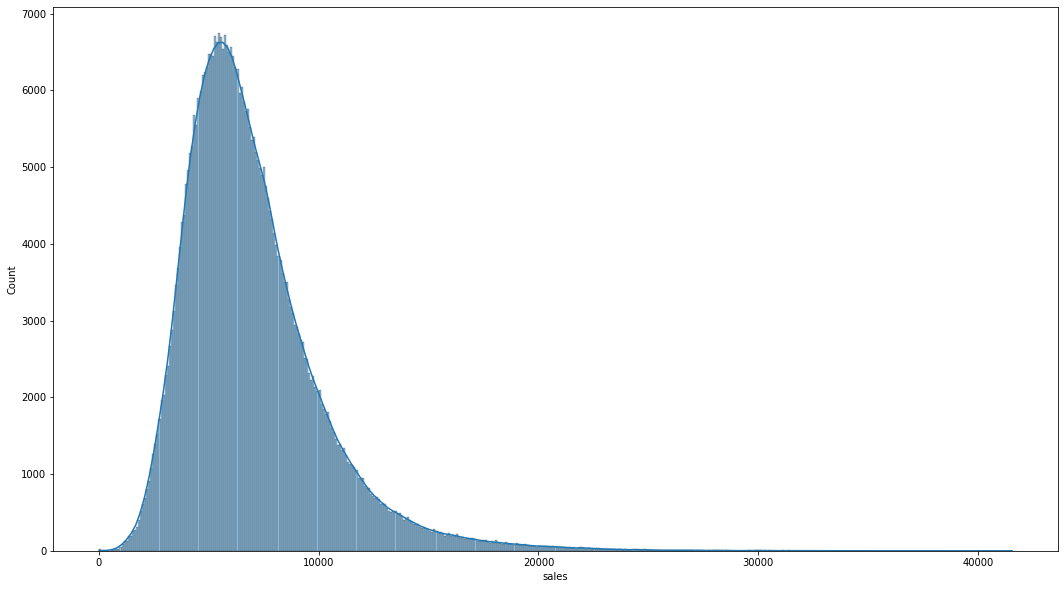

In [3]:
# Distribution Graph

plt.figure(figsize=(18,10))
sns.histplot(dados['sales'],kde=True);

In [4]:
# Descriptive Analysis

desc_dep = pd.DataFrame(dados['sales'].describe()).T
desc_dep['kurtosis'] = dados['sales'].kurtosis() # Add kurtosis
desc_dep['skew'] = dados['sales'].skew() # Add skew
desc_dep['range'] = dados['sales'].max() - dados['sales'].min() # Add range
desc_dep

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew,range
sales,422111.0,6954.921054,3111.385136,0.0,4855.0,6367.0,8359.0,41551.0,4.996137,1.611748,41551


Not a normal distribution, but well distributed.

Mean and Median almost the same (6300-6900 sales). But has skew and kurtosis not equal 3.

It's what i was expecting, positive skewness distribution. (Sales tend to have this behavior)

### 2.2.2 Independent Variables

In [5]:
# Store, Day of Week, State Holiday, School Holiday, Store Type, Assortment, Customers and Sales Per Customer

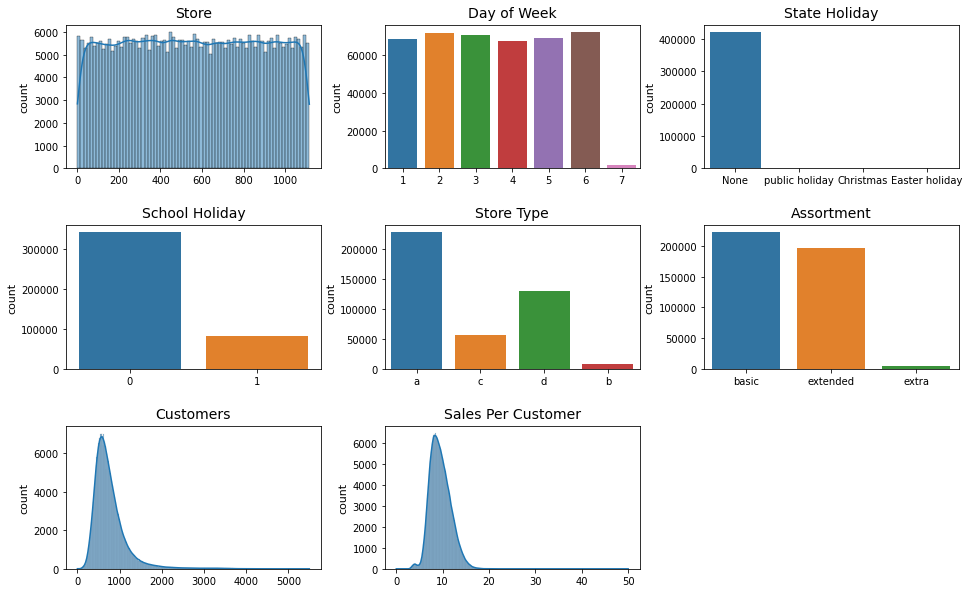

In [6]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.4,wspace=0.25)

plt.subplot(3,3,1)
ax = sns.histplot(dados['store'],kde=True)
ax.set_title('Store',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,2)
ax = sns.countplot(dados['day_of_week'])
ax.set_title('Day of Week',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,3)
ax = sns.countplot(dados['state_holiday'])
ax.set_title('State Holiday',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,4)
ax = sns.countplot(dados['school_holiday'])
ax.set_title('School Holiday',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,5)
ax = sns.countplot(dados['store_type'])
ax.set_title('Store Type',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,6)
ax = sns.countplot(dados['assortment'])
ax.set_title('Assortment',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,7)
ax = sns.histplot(dados['customers'],kde=True)
ax.set_title('Customers',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,8)
ax = sns.histplot(dados['sales_per_customer'],kde=True)
ax.set_title('Sales Per Customer',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.show()

What we can observe:

**Store:** We can consider that we have the same representation for all stores

**Day of Week:** In sunday it has way less represantation (Probably because the stores are closed this day)

**State Holiday and School Holiday:** Seems to behave as expected, more normal days and less holidays. 

**Store Type:** There's a visible predominance of some store types.

**Assortment:** more assortment == less representation

**Customers:** The peak of this distribution is less than 1000, but it has a positive skew as expected.

**Sales Per Customer:** We can see that most of the times we have values between 5 and 15, but it can reach around 50, positive skew as expected.

In [7]:
# competition, competition_distance, competition_lifetime, competition_open_since_month and competition_open_since_year

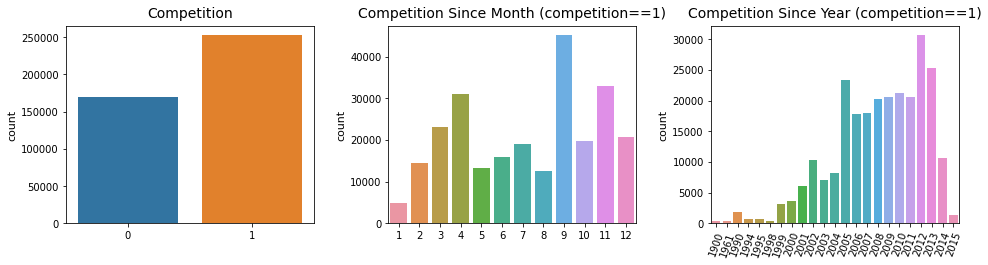

In [8]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,3,1)
ax = sns.countplot(dados['competition'])
ax.set_title('Competition',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,2)
ax = sns.countplot(dados[dados['competition']==1]['competition_open_since_month'])
ax.set_title('Competition Since Month (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,3)
ax = sns.countplot(dados[dados['competition']==1]['competition_open_since_year'])
ax.set_title('Competition Since Year (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)
plt.tick_params(axis='x',rotation=70)

plt.show()

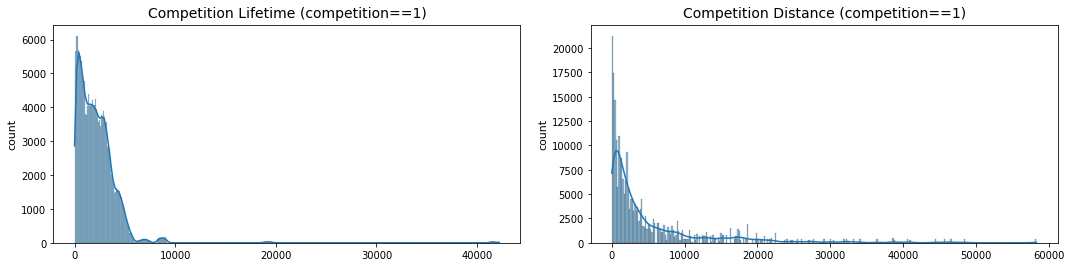

In [9]:
plt.figure(figsize=(18,4))
plt.subplots_adjust(wspace=0.15)
plt.subplot(1,2,1)
ax = sns.histplot(dados[dados['competition']==1]['competition_lifetime'],kde=True)
ax.set_title('Competition Lifetime (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(1,2,2)
ax = sns.histplot(dados[dados['competition']==1]['competition_distance'],kde=True)
ax.set_title('Competition Distance (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.show()

What we can observe:

**Competition:** We can see that almost every records are from stores with competition that already started

**Competition Distance:** Competitors are usually close to the stores, then the distribution has a positive skew

**Competition Lifetime:** The competition is recent in most cases, then the distribution has a positive skew

**Competition Open Since Month:** We have a peak of competition start in september for some reason, which probably is a interesting insight.

**Competition Open Since Year:** Most of the competitors are recent, as we saw in competition lifetime anaylis, since 2005 we more competitors opening.

**RESUMO:** A maioria das lojas tem competidores, geralmente são perto delas e a concorrência geralmente não tem mais de 10 anos. Uma coisa interessante é que setembro tem um pico competition since por algum motivo.

In [10]:
# promo, promo_count_per_week, promo_n, promo2, promo2_since_week, promo2_since_year, promo2_interval, promo2_lifetime

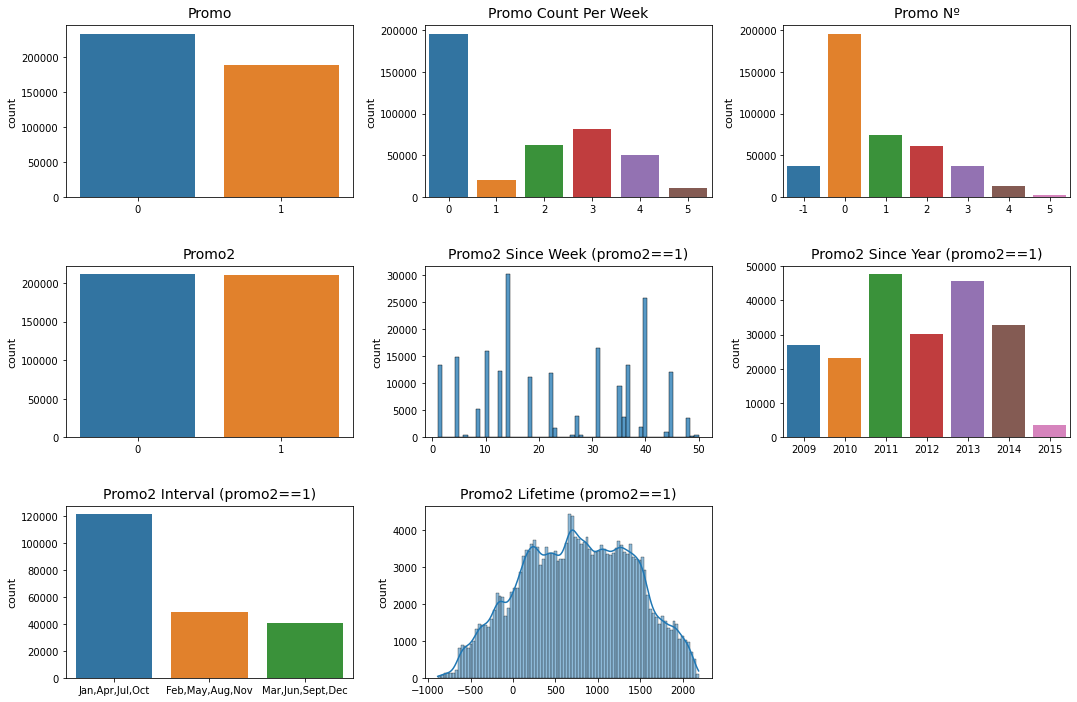

In [11]:
plt.figure(figsize=(18,12))
plt.subplots_adjust(hspace=0.4,wspace=0.25)

plt.subplot(3,3,1)
ax = sns.countplot(dados['promo'])
ax.set_title('Promo',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,2)
ax = sns.countplot(dados['promo_count_per_week'])
ax.set_title('Promo Count Per Week',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,3)
ax = sns.countplot(dados['promo_n'])
ax.set_title('Promo Nº',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,4)
ax = sns.countplot(dados['promo2'])
ax.set_title('Promo2',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,5)
ax = sns.histplot(dados[dados['promo2']==1]['promo2_since_week'])
ax.set_title('Promo2 Since Week (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,6)
ax = sns.countplot(dados[dados['promo2']==1]['promo2_since_year'])
ax.set_title('Promo2 Since Year (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,7)
ax = sns.countplot(dados[dados['promo2']==1]['promo_interval'])
ax.set_title('Promo2 Interval (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,8)
ax = sns.histplot(dados[dados['promo2']==1]['promo2_lifetime'],kde=True)
ax.set_title('Promo2 Lifetime (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)


plt.show()

What we can observe:

**Promo:** There's a huge represantation of promo, which means that almost every day we have promo

**Promo Count Per Week and Promo Nº:** It's what i expected, if we have promo, it's not a lot each week.

**Promo2:** Around a half of the stores adopted promo2, which is interesting, may have a huge impact on sales.

**Promo2 Since Week:** We have some periods with high and other with almost no acceptance. There must have a good reason for it.

**Promo2 Since Year:** In 2011 and 2013 we have two peaks of promo2 adoption, which is curious because in2012 and 2014 did not follow this behavior. We need to observe that 2015 has way less contribution compared to other years, probably because this data doesn't include the whole year of 2015.

**Promo2 Interval:** We have a visible difference between the interval adopted, there's one that is chosen most times and others with similar acceptance.

**Promo2 Lifetime:** Most of the records are with promo2 already running. We clearly see that most of these records are from promo2 which started no more than 1500 days ago (after that we have a notorious drop).

**RESUMO:** 
Temos muitas promos, mas por semana se tivermos temos até 2. Sobre promo2, vemos que há uma grande aceitabilidade (se as lojas adotaram a promo2, a maioria dos records são já com ela rodando), mas que existem períodos de uma maior adoção e outras com baixa ou nenhuma, da mesma forma há anos com mais sucesso e outros com menos, nada homogêneo!

In [11]:
# Quero conferir se promo2 == 1 só ocorre em valores positivos de promo2 lifetime
(dados[dados['promo2']==1]['promo2_lifetime']<0).sum()

29073

Essa variável não tá correta não, pois apesar da loja participar, ela não participa ainda naquele record!

In [12]:
# Precisamos fazer um data cleaning rápido!
dados['promo2'] = dados['promo2_lifetime'].apply(lambda x: 1 if x>=0 else 0)

In [15]:
# Vamos ver se esse mesmo fenômeno se repete com a feature promo interval
(dados[dados['promo_interval']!='No promo2']['promo2_lifetime']<0).sum()

29073

É exatamente a mesma coisa, a variável também precisa ser corrigida!

In [21]:
# Precisamos fazer um data cleaning rápido!
indexx = dados[(dados['promo_interval']!='No promo2')&(dados['promo2_lifetime']<0)].index
for index in indexx:
    dados.loc[index,'promo_interval'] = 'No promo2'

Pronto! Vamos continuar nossa análise.

In [12]:
# day, month, year, week, quarter, semester and season

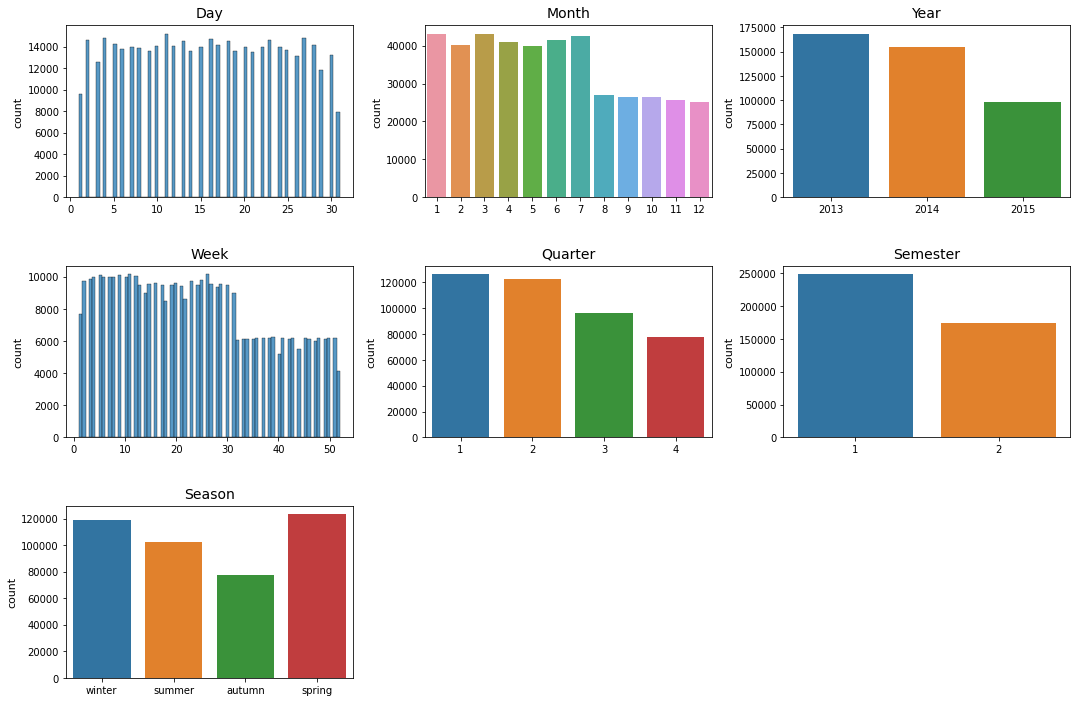

In [13]:
plt.figure(figsize=(18,12))
plt.subplots_adjust(hspace=0.4,wspace=0.25)

plt.subplot(3,3,1)
ax = sns.histplot(dados['day'])
ax.set_title('Day',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,2)
ax = sns.countplot(dados['month'])
ax.set_title('Month',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,3)
ax = sns.countplot(dados['year'])
ax.set_title('Year',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,4)
ax = sns.histplot(dados['week'])
ax.set_title('Week',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,5)
ax = sns.countplot(dados['quarter'])
ax.set_title('Quarter',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,6)
ax = sns.countplot(dados['semester'])
ax.set_title('Semester',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,7)
ax = sns.countplot(dados['season'])
ax.set_title('Season',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)


plt.show()

What we can observe:

**Day:** We have a similar representation between values, but the first and the last that of the month we have less records for some reason.

**Month, Week, Semester and Quarter:** Most of the records are from the first semester, probably because 2015 is not completed yet.

**Year:** As we talked all time, 2015 has less records. But 2014 has less than 2013 for some reason.

**Season:** Not have a equal distribution, probably because of the semesters representation difference

**RESUMO:** A distribuição de tempo no dataset não é muito bem distribuída, tem lacunas em algumas partes do ano e ao longo dos anos! Temos que considerar essa falta de homogeneidade para fazer nossas análises!

## 2.3 Bivariate Analysis

### H1: As lojas vendem mais no começo do mês do que no final

The hypotheis is **TRUE** and this feature seems to have a **HIGH** impact on Machine Learning Model.

Vemos que no ano como um todo se vende um pouco mais no começo do que no final, mas esse comportamento depende muito de que mês estamos falando. O que me chamou atenção é esse comportamento bem característico no primeiro gráfico, provavelmente será uma feature importante.

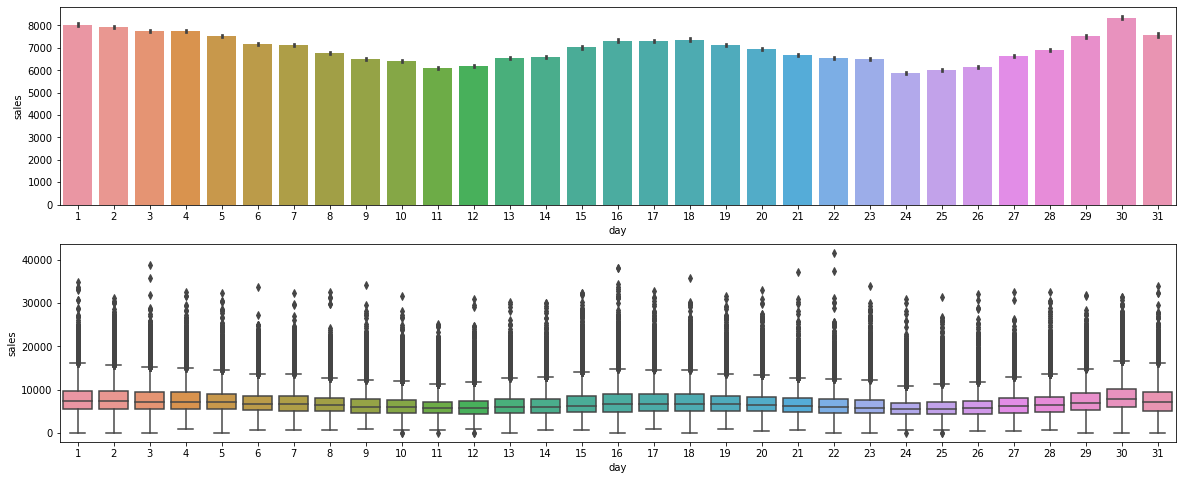

In [15]:
plt.figure(figsize=(20,8))

plt.subplot(2,1,1)
ax = sns.barplot(x=dados['day'],y=dados['sales'])

plt.subplot(2,1,2)
ax = sns.boxplot(x=dados['day'],y=dados['sales'])

plt.show()

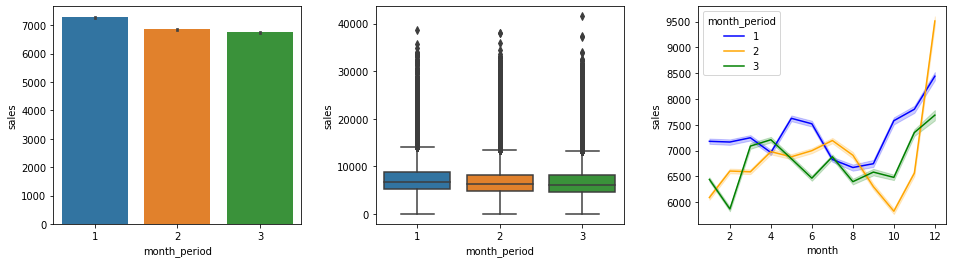

In [16]:
# 1 == 10 first days, 2 == 10 middle days, 3 == 10* (* == or 11) ending days
month_period = dados['day'].apply(lambda x: 1 if x<=10 else (2 if 20>=x>=11 else 3)) 

plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
ax = sns.barplot(x=month_period,y=dados['sales'])
ax.set_xlabel('month_period')

plt.subplot(1,3,2)
ax = sns.boxplot(x=month_period,y=dados['sales'])
ax.set_xlabel('month_period')

plt.subplot(1,3,3)
ax = sns.lineplot(x=dados['month'],y=dados['sales'],hue=month_period,palette=['blue','orange','green'])
ax.legend(title='month_period')
plt.show()

### H2: Houve um crescimento de vendas ao longo dos anos

The hypothesis ask for a absolute value analyses, but as we saw on the univariate analysis, these classes are not well balanced.

Then, analysing relative values, the hypothesis is **TRUE**, we can see this in graphs and with describe method.

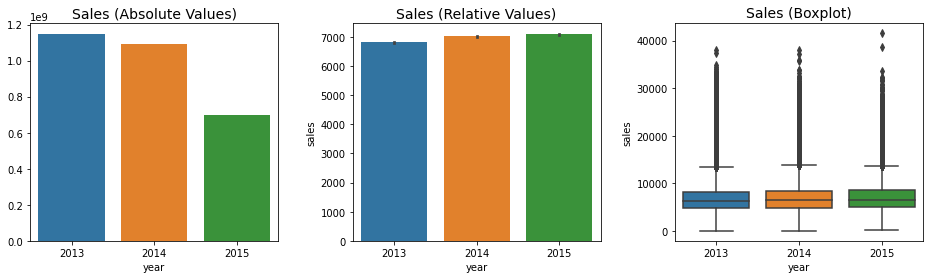

In [19]:
plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
ax = sns.barplot(x=dados.groupby('year').sum()['sales'].index,y=dados.groupby('year').sum()['sales'].values)
ax.set_title('Sales (Absolute Values)',size=14)

plt.subplot(1,3,2)
ax = sns.barplot(x=dados['year'],y=dados['sales'])
ax.set_title('Sales (Relative Values)',size=14)

plt.subplot(1,3,3)
ax = sns.boxplot(x=dados['year'],y=dados['sales'])
ax.set_title('Sales (Boxplot)',size=14)

plt.show()

In [20]:
# Descriptive Analysis of sales over the years
dados.groupby('year').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,168647.0,6814.300053,3129.719960,0.0,4712.0,6209.0,8182.0,38025.0
2014,155189.0,7022.904175,3136.213533,0.0,4896.0,6429.0,8454.0,38037.0
2015,98275.0,7088.882666,3029.919704,124.0,5046.0,6540.0,8500.0,41551.0


### H3: Lojas vendem mais no fim de semana

The hypothesis is **FALSE** and this feature seems to have a **HIGH** impact on ML model.

We can clearly see a high difference in the first 3 graphs, week days has way more sales all over the year. In the last 3 graphs we can see that sunday is the best day of the week for sales. So, why we can claim that this hypothesis is false? We need to remember what we observed in univariate analysis: most of times stores doesn't even open on sunday's. So probably the stores only opens on especific sundays, which they know that it will be very worth it! Beyond that, this feature also have a very particular behavior, for me it seems to have huge importance for the model that we will build.

About sales per customer: Mesmo com um claro volume de vendas menos no weekend, os consumidores não diminuem seu consumo. Outra descoberta interessante é que nos domingos que são abertos, onde vimos um volume de vendas muito maior que o usual, os consumidores consomem menos!

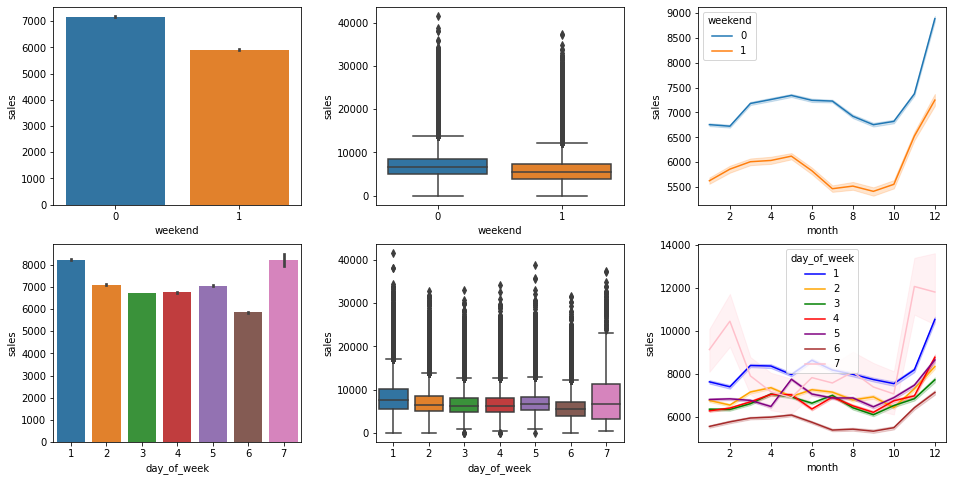

In [68]:
weekend = dados['day_of_week'].apply(lambda x: 1 if x==6 or x==7 else 0)

plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,3,1)
ax = sns.barplot(x=weekend,y=dados['sales'])
ax.set_xlabel('weekend')

plt.subplot(2,3,2)
ax = sns.boxplot(x=weekend,y=dados['sales'])
ax.set_xlabel('weekend')

plt.subplot(2,3,3)
ax = sns.lineplot(x=dados['month'],y=dados['sales'],hue=weekend)
ax.legend(title='weekend')

plt.subplot(2,3,4)
sns.barplot(x=dados['day_of_week'],y=dados['sales'])

plt.subplot(2,3,5)
sns.boxplot(x=dados['day_of_week'],y=dados['sales'])

plt.subplot(2,3,6)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['day_of_week'],palette=['blue','orange','green','red','purple','brown','pink'])

plt.show()

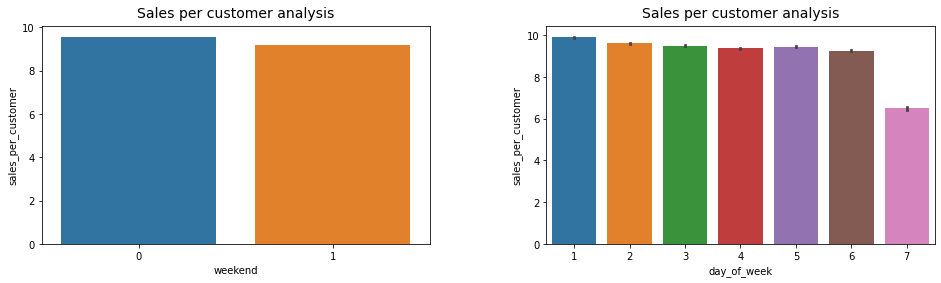

In [29]:
# sales per customer analysis

weekend = dados['day_of_week'].apply(lambda x: 1 if x==6 or x==7 else 0)

plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
ax = sns.barplot(x=weekend,y=dados['sales_per_customer'])
ax.set_xlabel('weekend')
ax.set_title('Sales per customer analysis',fontsize=14,pad=9)

plt.subplot(1,2,2)
ax = sns.barplot(x=dados['day_of_week'],y=dados['sales_per_customer'])
ax.set_title('Sales per customer analysis',fontsize=14,pad=9)

plt.show()

### H4: Lojas vendem mais em feriados

For The hypothesis is **FALSE** for School Holidays and **TRUE** for State Holidays

Os feriados do tipo 'State Holiday' possuem distribuições menos comportadas, mas em geral com valores maiores do que dias normais. About sales per customer: Impressionantemente, mesmo com menores vendas, os consumidores gastam mais em dias normais!

Os feriados do tipo 'School Holiday' em uma primeira vista parecem vender apenas um pouco mais, mas se analisarmos ao longo do tempo vemos que existem períodos, mesmo que curtos, especialmente em dois meses, que o inverso ocorre. Então, não podemos afirmar que essa hipótese é verdadeira.

In [69]:
# State holiday (w/ sales per customer analysis)

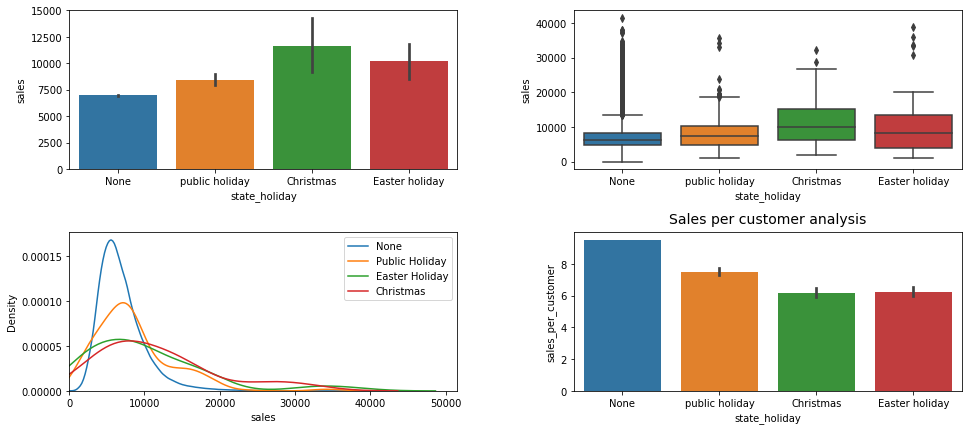

In [30]:
plt.figure(figsize=(16,7))
plt.subplots_adjust(wspace=0.3,hspace=0.4)

plt.subplot(2,2,1)
sns.barplot(x=dados['state_holiday'],y=dados['sales'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['state_holiday'],y=dados['sales'])

plt.subplot(2,2,3)
sns.kdeplot(dados[dados['state_holiday']=='None']['sales'])
sns.kdeplot(dados[dados['state_holiday']=='public holiday']['sales'])
sns.kdeplot(dados[dados['state_holiday']=='Easter holiday']['sales'])
sns.kdeplot(dados[dados['state_holiday']=='Christmas']['sales'])
plt.legend(['None','Public Holiday','Easter Holiday','Christmas'])
plt.xlim(dados['sales'].min())

plt.subplot(2,2,4)
ax = sns.barplot(x=dados['state_holiday'],y=dados['sales_per_customer'])
ax.set_title('Sales per customer analysis',fontsize=14,pad=9)

plt.show()

In [197]:
# School Holiday (w/ sales per customer analysis)

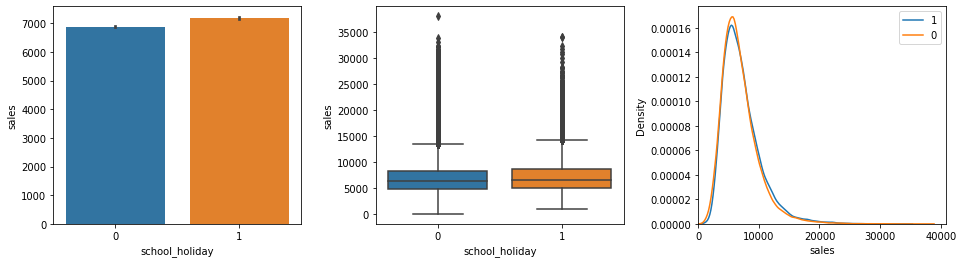

In [198]:
plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
sns.barplot(x=dados['school_holiday'],y=dados['sales'])

plt.subplot(1,3,2)
sns.boxplot(x=dados['school_holiday'],y=dados['sales'])

plt.subplot(1,3,3)
sns.kdeplot(dados[dados['school_holiday']==1]['sales'])
sns.kdeplot(dados[dados['school_holiday']==0]['sales'])
plt.legend(['1','0'])
plt.xlim(dados['sales'].min())

plt.show()

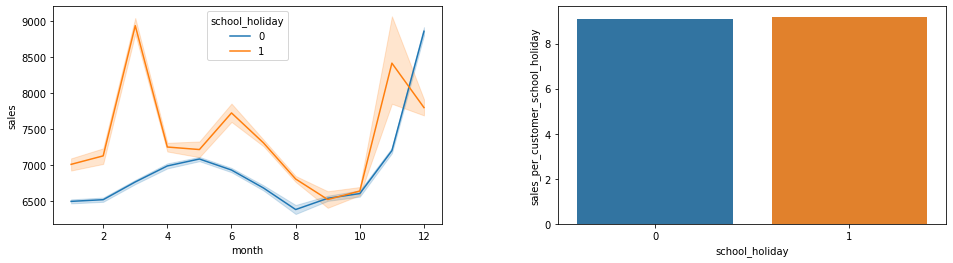

In [252]:
# Want to see if this 'no difference' between classes is present in the whole year

plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['school_holiday']);

plt.subplot(1,2,2)
sns.barplot(x=dados['school_holiday'],y=dados['sales_per_customer_school_holiday']);

plt.show()

We need to investigate this different behavior, because at the first look the classes seems to have no impact on sales.

In [200]:
# Let's go deeper and analyse using descriptive analysis
df_aux = pd.DataFrame()
df_aux1 = dados[dados['school_holiday']==1].groupby('month').describe()['sales']
df_aux0 = dados[dados['school_holiday']==0].groupby('month').describe()['sales']
for column in df_aux1.columns.values:
    df_aux[f'{column} sc==0'] = df_aux0[column]
    df_aux[f'{column} sc==1'] = df_aux1[column]
    df_aux[f'{column} diff sc1 - sc0'] = df_aux[f'{column} sc==1']-df_aux[f'{column} sc==0']
    df_aux[f'{column} pct sc1/sc0'] = round(((df_aux[f'{column} sc==1']/df_aux[f'{column} sc==0'])-1)*100,2)
    df_aux[f'{column}'] = pd.Series([0,0,0,0,0,0,0,0,0,0,0,0,0])
df_aux

,count sc==0,count sc==1,count diff sc1 - sc0,count pct sc1/sc0,count,mean sc==0,mean sc==1,mean diff sc1 - sc0,mean pct sc1/sc0,mean,std sc==0,std sc==1,std diff sc1 - sc0,std pct sc1/sc0,std,min sc==0,min sc==1,min diff sc1 - sc0,min pct sc1/sc0,min,25% sc==0,25% sc==1,25% diff sc1 - sc0,25% pct sc1/sc0,25%,50% sc==0,50% sc==1,50% diff sc1 - sc0,50% pct sc1/sc0,50%,75% sc==0,75% sc==1,75% diff sc1 - sc0,75% pct sc1/sc0,75%,max sc==0,max sc==1,max diff sc1 - sc0,max pct sc1/sc0,max
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14899.0,2227.0,-12672.0,-85.05,0,6519.518290,7006.862595,487.344306,7.48,0,2816.059047,2983.266680,167.207633,5.94,0,0.0,1198.0,1198.0,inf,0,4613.00,4991.50,378.50,8.21,0,6029.0,6426.0,397.0,6.58,0,7859.50,8405.50,546.00,6.95,0,32263.0,32228.0,-35.0,-0.11,0
2,14548.0,1384.0,-13164.0,-90.49,0,6492.128196,7242.730491,750.602295,11.56,0,2810.086002,3262.302220,452.216218,16.09,0,625.0,1641.0,1016.0,162.56,0,4617.00,5027.75,410.75,8.90,0,6028.5,6684.5,656.0,10.88,0,7790.00,8583.00,793.00,10.18,0,31448.0,31649.0,201.0,0.64,0
3,15659.0,1482.0,-14177.0,-90.54,0,6741.606808,8885.419703,2143.812896,31.80,0,2977.891935,3641.195352,663.303417,22.27,0,599.0,2141.0,1542.0,257.43,0,4741.00,6266.50,1525.50,32.18,0,6172.0,8305.5,2133.5,34.57,0,8096.00,10671.25,2575.25,31.81,0,28165.0,30729.0,2564.0,9.10,0
4,12514.0,4001.0,-8513.0,-68.03,0,6993.815007,7201.268183,207.453176,2.97,0,3118.830573,3149.850349,31.019777,0.99,0,416.0,1250.0,834.0,200.48,0,4851.50,4975.00,123.50,2.55,0,6414.5,6493.0,78.5,1.22,0,8496.00,8672.00,176.00,2.07,0,30848.0,29944.0,-904.0,-2.93,0
5,14777.0,1242.0,-13535.0,-91.60,0,7077.202680,7338.587762,261.385082,3.69,0,2953.281076,3226.165145,272.884069,9.24,0,923.0,2272.0,1349.0,146.15,0,5112.00,5117.25,5.25,0.10,0,6581.0,6737.5,156.5,2.38,0,8489.00,8752.50,263.50,3.10,0,33151.0,34133.0,982.0,2.96,0
6,15498.0,1176.0,-14322.0,-92.41,0,6943.552587,7745.228741,801.676154,11.55,0,3129.248048,3229.557069,100.309020,3.21,0,0.0,2409.0,2409.0,inf,0,4857.25,5472.75,615.50,12.67,0,6296.0,7070.5,774.5,12.30,0,8307.75,9319.00,1011.25,12.17,0,31477.0,27177.0,-4300.0,-13.66,0
7,9444.0,7719.0,-1725.0,-18.27,0,6699.277319,7311.012307,611.734988,9.13,0,2865.273620,3134.453509,269.179889,9.39,0,943.0,1143.0,200.0,21.21,0,4756.75,5095.00,338.25,7.11,0,6227.0,6724.0,497.0,7.98,0,8053.75,8829.00,775.25,9.63,0,30112.0,27508.0,-2604.0,-8.65,0
8,4126.0,6770.0,2644.0,64.08,0,6360.342705,6797.103250,436.760545,6.87,0,3164.460540,2781.390174,-383.070365,-12.11,0,316.0,1007.0,691.0,218.67,0,4309.00,4859.25,550.25,12.77,0,5802.5,6304.5,502.0,8.65,0,7703.25,8178.75,475.50,6.17,0,33913.0,23970.0,-9943.0,-29.32,0
9,9668.0,873.0,-8795.0,-90.97,0,6527.875052,6515.844215,-12.030836,-0.18,0,2840.517568,2779.255562,-61.262006,-2.16,0,740.0,1573.0,833.0,112.57,0,4623.00,4407.00,-216.00,-4.67,0,5961.0,6020.0,59.0,0.99,0,7824.25,7809.00,-15.25,-0.19,0,29777.0,21535.0,-8242.0,-27.68,0


### H5: Lojas vendem mais no verão

The hypothesis is **FALSE**

Há mais vendas, em todos os anos, nos períodos de primavera e outono (Apenas é necessário lembrar que não temos registros do outono de 2015)

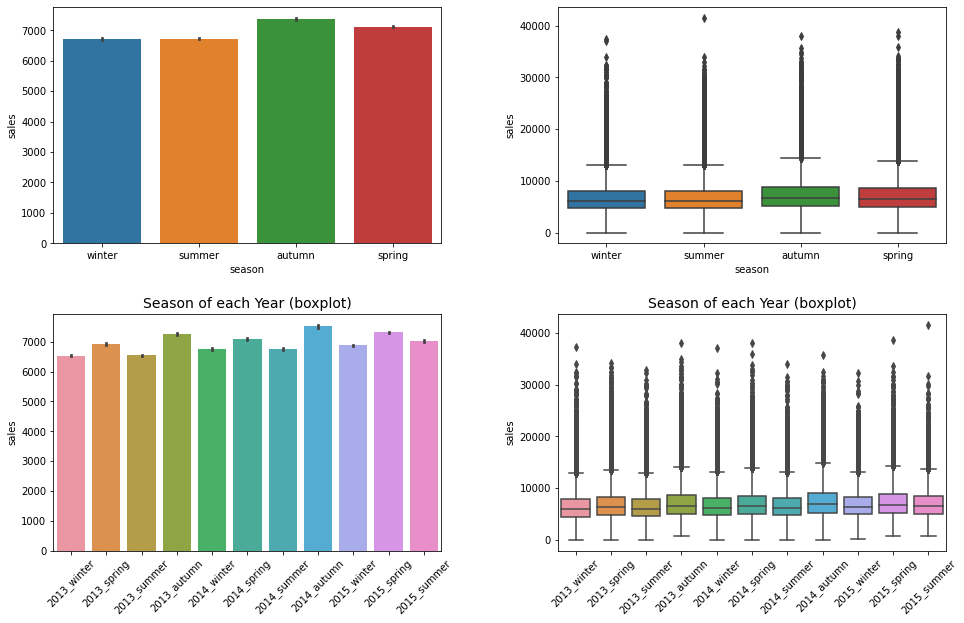

In [32]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.3,hspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['season'],y=dados['sales'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['season'],y=dados['sales'])


# Let's see if this happens every year
plt.subplot(2,2,3)
year_season = dados.apply(lambda x: str(x['year'])+'_'+str(x['season']), axis=1)
order = ['2013_winter', '2013_spring', '2013_summer', '2013_autumn','2014_winter', '2014_spring', '2014_summer', '2014_autumn','2015_winter','2015_spring', '2015_summer']
ax = sns.barplot(x=year_season,y=dados['sales'],order=order)
ax.set_title('Season of each Year (boxplot)',size=14)
plt.tick_params(axis='x',rotation=45)

plt.subplot(2,2,4)
ax = sns.boxplot(x=year_season,y=dados['sales'],order=order)
ax.set_title('Season of each Year (boxplot)',size=14)
plt.tick_params(axis='x',rotation=45)

plt.show()

### H6: Se a loja tem competidor ela vende menos

The hypothesis is **TRUE**

Vemos uma diferença sutil nos gráficos observados, o que foi confirmado com a análise descritiva, mas ela existe, assim como esperávamos.

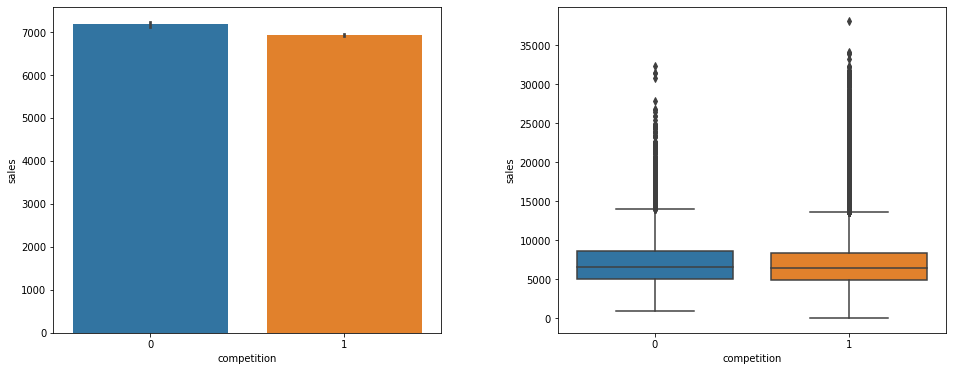

In [205]:
plt.figure(figsize=(16,6))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['competition'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['competition'],y=dados['sales'])

plt.show()

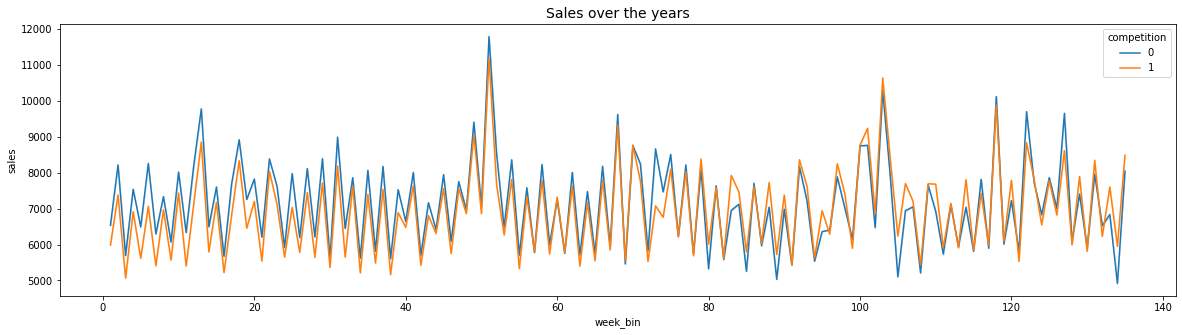

In [206]:
# let's see if this occurred all over the years

plt.figure(figsize=(20,5))
ax = sns.lineplot(dados['week_bin'],dados['sales'],hue=dados['competition'],ci=False)
ax.set_title('Sales over the years',size=14)
plt.show()

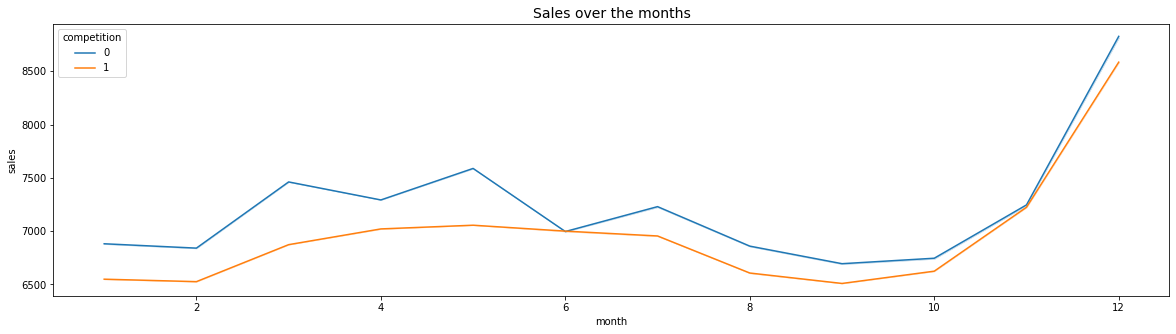

In [207]:
# let's see if this occurred all over the month

plt.figure(figsize=(20,5))
ax = sns.lineplot(dados['month'],dados['sales'],hue=dados['competition'],ci=False)
ax.set_title('Sales over the months',size=14)
plt.show()

### H7: Quanto mais velha é a competição, menos a loja vende

Tendência quase nula, reta de regressão na horizontal! 

Logo, baseado nessas informações que temos: This hypothesis is **FALSE**

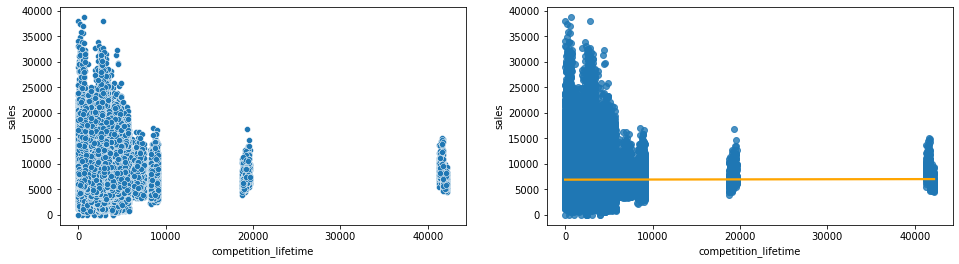

In [19]:
df_aux = dados[dados['competition']==1] # In this hypothesis I need to analyse stores that have competititors 

plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_lifetime'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_lifetime'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [20]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_lifetime','sales']))

Coeficiente de Correlação de Pearson: 0.0018458520195225457


Acho que esses dois focos, em x = 20000 e 40000 são de duas lojas específicas que podem atrapalhar nossa análise, são claramente outliers.

In [21]:
# Finding how many stores are
print('Quantidade de lojas dos dois focos: {} stores'.format(dados[dados['competition_lifetime']>15000]['store'].unique().shape[0]))

Quantidade de lojas dos dois focos: 2 stores


São de fato duas lojas que estão atrapalhando, vamos retirá-las para vermos melhor a tendência no gráfico de dispersão.

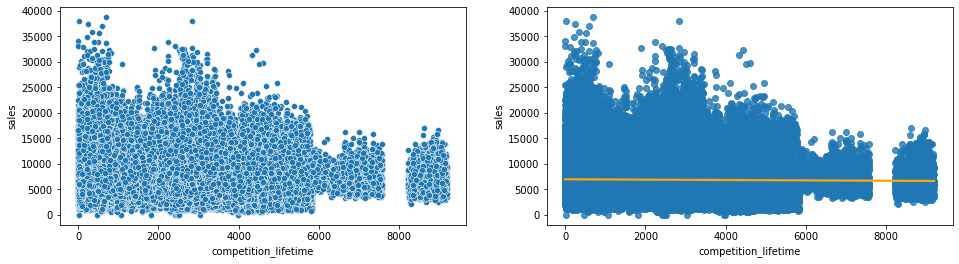

In [22]:
df_aux = df_aux[df_aux['competition_lifetime']<15000] # Removing these two stores

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_lifetime'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_lifetime'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [23]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_lifetime','sales']))

Coeficiente de Correlação de Pearson: -0.017683954926754102


### H8 Quanto mais longe é o competidor, mais vende a loja

Tendência quase nula, reta de regressão na horizontal! 

Logo, baseado nessas informações que temos: This hypothesis is **FALSE**

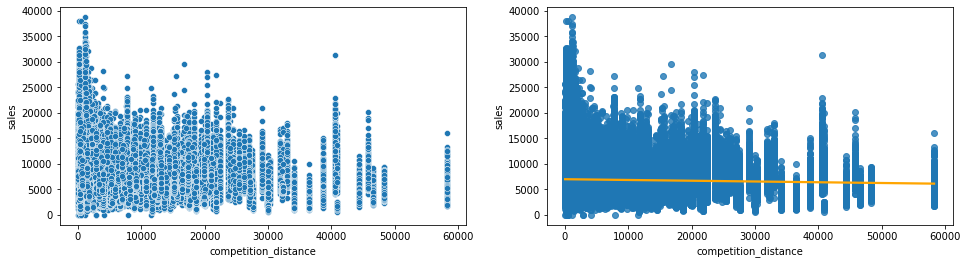

In [29]:
df_aux = dados[dados['competition']==1] # In this hypothesis I need to analyse stores that have competititors 

plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_distance'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_distance'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [30]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_distance','sales']))

Coeficiente de Correlação de Pearson: -0.037517955119866164


### H9: Existem tipos de loja que vendem substancialmente mais

This hypothesis is **TRUE** and this feature seems to have a **HUGE** impact on ML model.

Vemos claramente que existe um tipo de loja que vende muito mais que os outros, o tipo B, apesar de ter uma distribuição bem menos comportada. About sales per customer: em contrapartida, vemos que o B é o que menos vende por consumidor, e o tipo D é o que mais vende! Me chama também atenção para esses outliers, principalmente no store type C, demonstrando que esse store type pode ter um potencial enorme de aumentar o ticket médio!

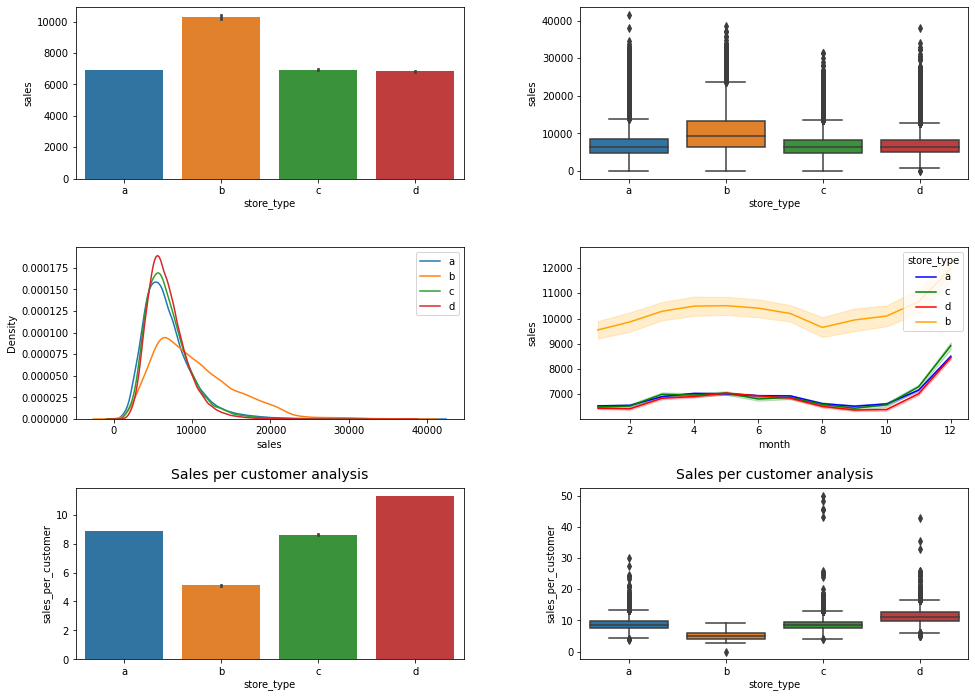

In [37]:
plt.figure(figsize=(16,12))
plt.subplots_adjust(wspace=0.3,hspace=0.4)

plt.subplot(3,2,1)
sns.barplot(x=dados['store_type'],y=dados['sales'],order=['a','b','c','d'])

plt.subplot(3,2,2)
sns.boxplot(x=dados['store_type'],y=dados['sales'],order=['a','b','c','d'])

plt.subplot(3,2,3)
sns.kdeplot(x=dados[dados['store_type']=='a']['sales'])
sns.kdeplot(x=dados[dados['store_type']=='b']['sales'])
sns.kdeplot(x=dados[dados['store_type']=='c']['sales'])
sns.kdeplot(x=dados[dados['store_type']=='d']['sales'])
plt.legend(['a','b','c','d'])

plt.subplot(3,2,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['store_type'],palette=['blue','green','red','orange'])

plt.subplot(3,2,5)
ax = sns.barplot(x=dados['store_type'],y=dados['sales_per_customer'],order=['a','b','c','d'])
ax.set_title('Sales per customer analysis',fontsize=14,pad=9)

plt.subplot(3,2,6)
ax = sns.boxplot(x=dados['store_type'],y=dados['sales_per_customer'],order=['a','b','c','d'])
ax.set_title('Sales per customer analysis',fontsize=14,pad=9)

plt.show()

### H10: Quanto mais diversa é a loja, mais ela vende

This Hypothesis is **TRUE** and this feature seems to have a **HUGE** impact on ML model.

É visível uma correlação positiva na relação entre assortment e sales. A extra desponta como a com maior volume de vendas, seguida pela extended e depois pela basic. About sales per customer: Da mesma forma que o store type, o resultado foi contra intuitivo, com extra sendo a com pior desempenho e a extended com maior, demonstrando que para o consumidor desembolsar mais, ele deve ter uma variedade mediana. Uma coisa que também me chamou atenção é são os outliers do tipo extended, que mostram um potencial enorme desse tipo de assortment de aumentar o ticket médio da empresa.

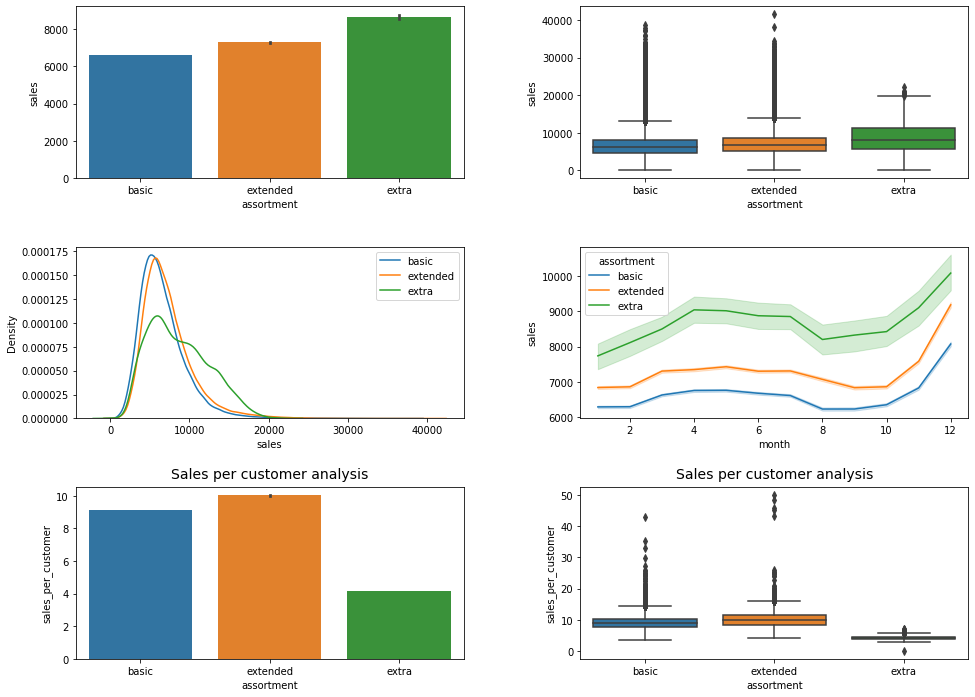

In [38]:
plt.figure(figsize=(16,12))
plt.subplots_adjust(wspace=0.3,hspace=0.4)

plt.subplot(3,2,1)
sns.barplot(x=dados['assortment'],y=dados['sales'],order=['basic','extended','extra'])

plt.subplot(3,2,2)
sns.boxplot(x=dados['assortment'],y=dados['sales'],order=['basic','extended','extra'])

plt.subplot(3,2,3)
sns.kdeplot(x=dados[dados['assortment']=='basic']['sales'])
sns.kdeplot(x=dados[dados['assortment']=='extended']['sales'])
sns.kdeplot(x=dados[dados['assortment']=='extra']['sales'])
plt.legend(['basic','extended','extra'])

plt.subplot(3,2,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['assortment'])

plt.subplot(3,2,5)
ax = sns.barplot(x=dados['assortment'],y=dados['sales_per_customer'],order=['basic','extended','extra'])
ax.set_title('Sales per customer analysis',fontsize=14,pad=9)

plt.subplot(3,2,6)
ax = sns.boxplot(x=dados['assortment'],y=dados['sales_per_customer'],order=['basic','extended','extra'])
ax.set_title('Sales per customer analysis',fontsize=14,pad=9)

plt.show()

### H11: Quando tem promoção as lojas vendem mais

This hypothesis is **TRUE** and this variable seems to have a **HUGE** impact on ML model.

É clara a diferença entre promo e sem promo, salto enorme de vendas!

Há algo que me chamou a atenção: não existem promo no weekend, o que pode explicar o porquê de vender tão mal nesse período, como visto na H3.

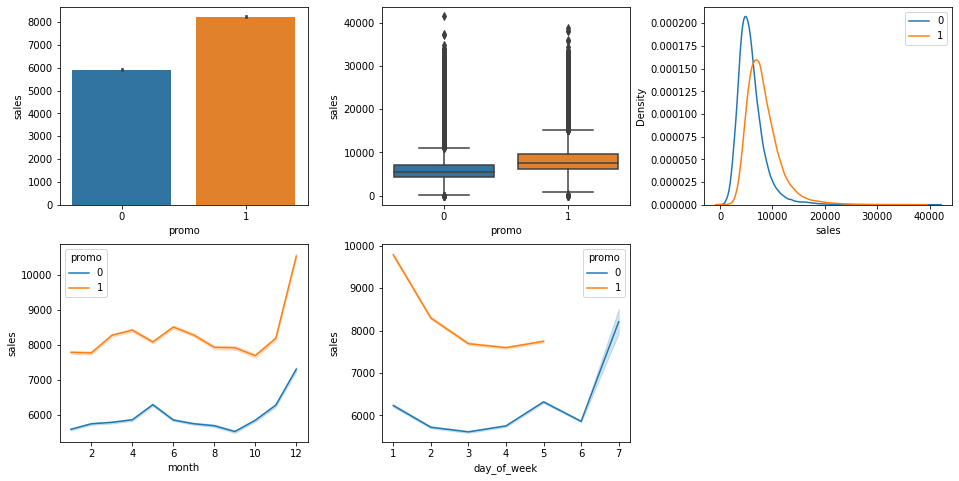

In [59]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,3,1)
sns.barplot(x=dados['promo'],y=dados['sales'])

plt.subplot(2,3,2)
sns.boxplot(x=dados['promo'],y=dados['sales'])

plt.subplot(2,3,3)
sns.kdeplot(x=dados[dados['promo']==0]['sales'])
sns.kdeplot(x=dados[dados['promo']==1]['sales'])
plt.legend(['0','1'])

plt.subplot(2,3,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['promo'])

plt.subplot(2,3,5)
sns.lineplot(x=dados['day_of_week'],y=dados['sales'],hue=dados['promo'])

plt.show()

### H12: Quanto mais vezes se tem promoção em um período, menos eficaz ela fica

This hypothesis is **FALSE** and this feature seems to have a **HUGE** impact on ML model.

A gente claramente vê que os dias entre promoções são iguais àqueles de semanas sem promoção, não há uma queda nas vendas. O que vemos é que o primeiro dia é o mais efetivo e que há uma queda na efetividade na segunda promoção em diante, mas mantendo um volume de vendas regular, ainda bem superior à dias sem promo.

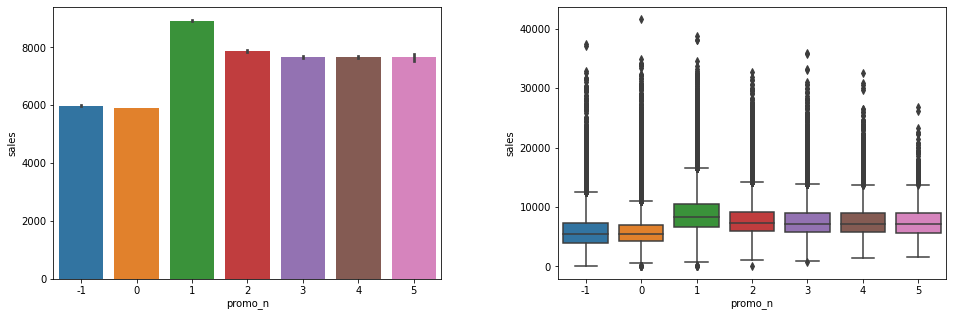

In [52]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['promo_n'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['promo_n'],y=dados['sales'])

plt.show()

In [53]:
# Descriptive Analysis

dados.groupby('promo_n').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo_n,,,,,,,,
-1,37840.0,5990.611549,3033.621723,124.0,3964.75,5491.0,7360.00,37376.0
0,195815.0,5908.154963,2537.791409,0.0,4276.00,5448.0,6937.00,41551.0
1,74886.0,8922.874796,3440.908513,0.0,6570.00,8326.0,10542.00,38722.0
2,61502.0,7873.653426,2964.447821,0.0,5890.00,7352.0,9202.00,32764.0
3,36731.0,7679.984291,2884.189181,816.0,5745.00,7178.0,8982.50,35909.0
4,13317.0,7670.179920,2860.269747,1426.0,5763.00,7179.0,8958.00,32529.0
5,2020.0,7662.104950,2866.986898,1542.0,5680.00,7145.0,8917.25,26869.0


### H13: Quanto mais vezes se tem promoção em um período, mais a loja vende

This hypothesis is **FALSE**

Vemos muita pouca diferença e na análise descritiva fica claro, apesar da tendência, que 5 promos vendem menos que 4, então não poderíamos concluir que essa hipótese é verdadeira!

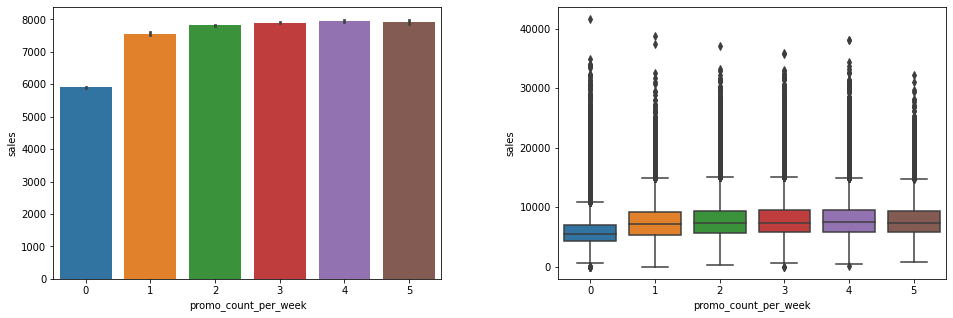

In [59]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['promo_count_per_week'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['promo_count_per_week'],y=dados['sales'])

plt.show()

In [60]:
# Descriptive Analysis

dados.groupby('promo_count_per_week').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo_count_per_week,,,,,,,,
0,195815.0,5908.154963,2537.791409,0.0,4276.00,5448.0,6937.00,41551.0
1,20069.0,7567.209776,3364.643855,0.0,5331.00,7070.0,9134.00,38722.0
2,62155.0,7815.428912,3280.125298,316.0,5629.00,7304.0,9391.00,37122.0
3,81966.0,7903.879230,3254.969630,0.0,5739.00,7362.0,9436.00,35909.0
4,50970.0,7948.962056,3249.849848,124.0,5784.00,7425.0,9435.75,38037.0
5,11136.0,7920.351922,3281.680028,804.0,5738.75,7329.0,9339.00,32170.0


### H14: Se a loja acatar a promo2 ela vende mais

This hipothesis is **FALSE** and this feature seems to have a **HUGE** impact on ML model.

Certamente isso é um grande insight para a empresa: a promo2 na verdade diminui o volume de vendas da loja! About sales per customer: Incrivelmente vemos que lojas com promo2 fazem os consumidores gastarem mais, o que é bem contra intuitivo com a conclusão anterior. Além disso, a distribuição é bem menos comportada, demonstrando que as lojas que adotam atingem tickets algumas vezes bem maiores.

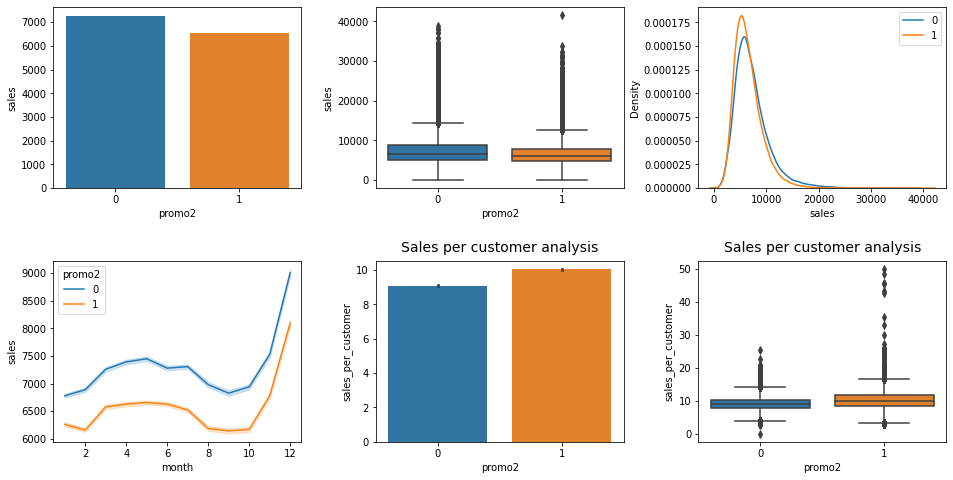

In [22]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3,hspace=0.4)

plt.subplot(2,3,1)
sns.barplot(x=dados['promo2'],y=dados['sales'])

plt.subplot(2,3,2)
sns.boxplot(x=dados['promo2'],y=dados['sales'])

plt.subplot(2,3,3)
sns.kdeplot(x=dados[dados['promo2']==0]['sales'])
sns.kdeplot(x=dados[dados['promo2']==1]['sales'])
plt.legend(['0','1'])

plt.subplot(2,3,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['promo2'])

plt.subplot(2,3,5)
ax = sns.barplot(x=dados['promo2'],y=dados['sales_per_customer'])
ax.set_title('Sales per customer analysis',fontsize=14,pad=9)

plt.subplot(2,3,6)
ax = sns.boxplot(x=dados['promo2'],y=dados['sales_per_customer'])
ax.set_title('Sales per customer analysis',fontsize=14,pad=9)

plt.show()

### H15: Existem períodos onde a promo2 é mais eficaz em relação às vendas

This hypothesis is **TRUE** and seems to be very important for the ML model. (It complements promo2 feature)

Há claras mudanças no volume de vendas, as quais podem ser percebidas no gráfico, demonstrando maior volume de vendas em alguns intervals.

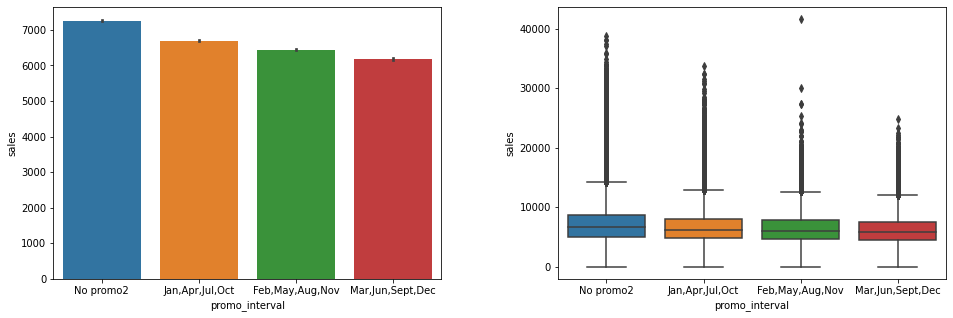

In [23]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['promo_interval'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['promo_interval'],y=dados['sales'])

plt.show()

### H16: Quanto mais antiga a promo2, menos a loja vende

This hypothesis is **TRUE**

A relação é bem fraca, mas ainda existente, ela diz que quanto mais velha, mais se vende e quanto mais nova menos se vende.

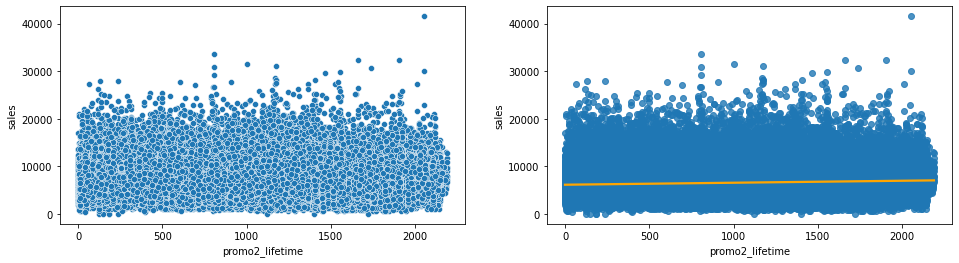

In [24]:
df_aux = dados[dados['promo2']==1] # In this hypothesis I need to analyse stores that have promo2 

plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['promo2_lifetime'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['promo2_lifetime'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [25]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['promo2_lifetime','sales']))

Coeficiente de Correlação de Pearson: 0.08273904592165846


## 2.3 Multivariate Analysis

### Correlation Matrix

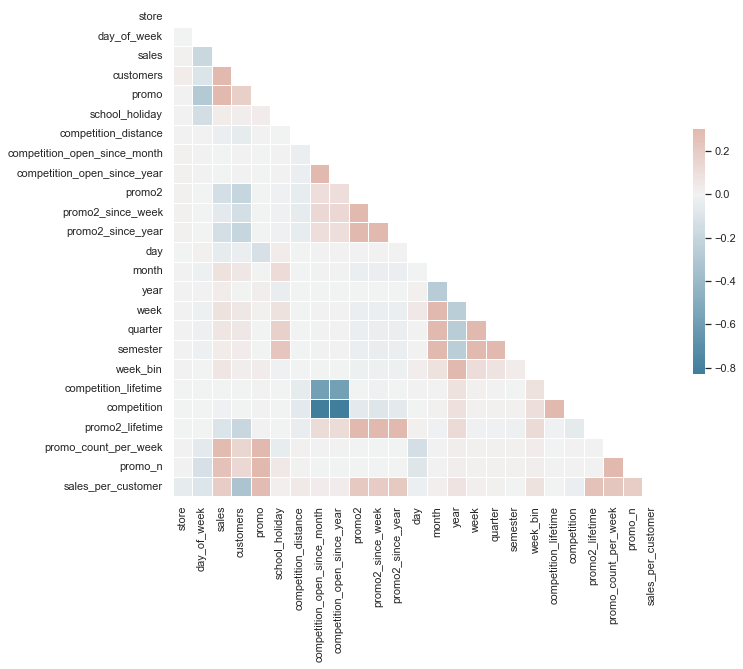

In [85]:
# Using seaborn diagonal correlation matrix: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set_theme(style="white")

# Compute the correlation matrix
corr = dados.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### H1: Assortment == Store type ?

This hypothesis is **FALSE**.

São coisas diferentes, as store_types apresentam variedades de assortment, mas é interessante que o extra é apenas presente em lojas do tipo B.

In [89]:
for store_type in np.unique(dados['store_type']):
    print(store_type.upper())
    print(dados[dados['store_type']==store_type]['assortment'].value_counts(normalize=True))
    print('')

A
basic       0.625458
extended    0.374542
Name: assortment, dtype: float64

B
extra       0.534049
basic       0.404753
extended    0.061198
Name: assortment, dtype: float64

C
basic       0.518056
extended    0.481944
Name: assortment, dtype: float64

D
extended    0.638028
basic       0.361972
Name: assortment, dtype: float64



### H2: As competições estão cada vez mais próximas

This hypothesis is **FALSE**.

Vemos claramente que a correlação é muito pequena, quase nula!

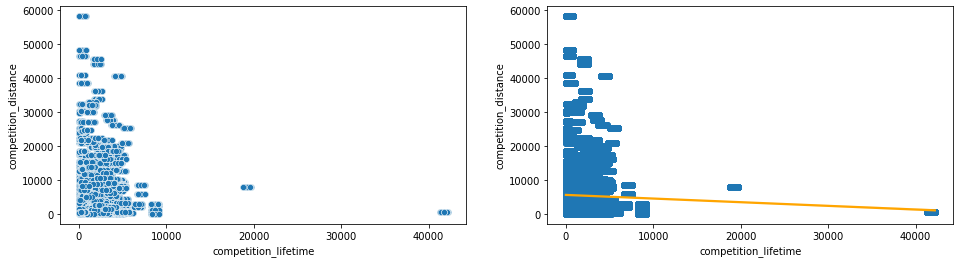

In [90]:
df_aux = dados[dados['competition']==1] # In this hypothesis I need to analyse stores that have competititors 

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_lifetime'],y=df_aux['competition_distance'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_lifetime'],y=df_aux['competition_distance'],line_kws={"color": "orange"})

plt.show()

In [91]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_lifetime','competition_distance']))

Coeficiente de Correlação de Pearson: -0.029613870827970633


Temos alguns records atrapalhando a análise do comportamento geral, vou retirá-los por enquanto.

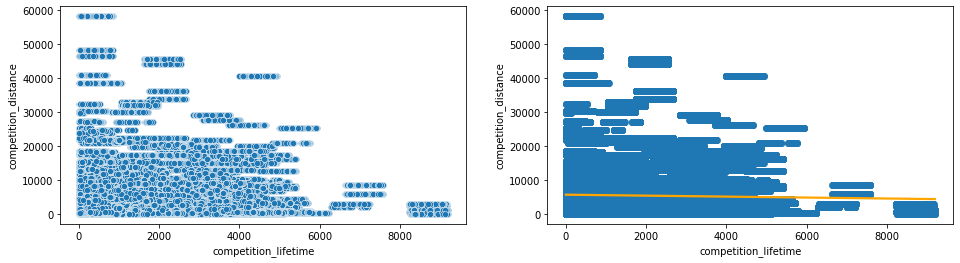

In [92]:
df_aux = dados[(dados['competition']==1)&(dados['competition_lifetime']<15000)] # In this hypothesis I need to analyse stores that have competititors 

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_lifetime'],y=df_aux['competition_distance'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_lifetime'],y=df_aux['competition_distance'],line_kws={"color": "orange"})

plt.show()

In [93]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_lifetime','competition_distance']))

Coeficiente de Correlação de Pearson: -0.027368037310373232


## Exporting Dataset (After Exploratory Data Analysis)

In [27]:
# Já que já acabamos a EDA, vou dropar qualquer feature relacionada com customers pelos motivos que já abordamos no data cleaning
# Além disso, nessa etapa também foi corrigida a variável promo2 e promo_interval (na univariate analysis analysis)
dados.drop(['customers','sales_per_customer'],axis=1,inplace=True)

In [28]:
dados.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_eda2.csv',index=False)

# 3.0 Data Preprocessing

## Import Data

In [4]:
dados = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_eda2.csv')

## 3.1 Encoding

In [5]:
# Target Encoding
te = TargetEncoder(cols=['store_type','promo_interval'],return_df=True)

# Ordinal Encoding
oe = OrdinalEncoder(cols=['assortment','season'],mapping=[{'col': 'assortment', 'mapping': {'basic': 0, 'extended': 1, 'extra': 2}},{'col': 'season', 'mapping': {'winter': 0, 'spring': 1, 'summer': 2,'autumn':3}}])

# One Hot Encoding
ohe = OneHotEncoder(cols=['state_holiday'],return_df=True,use_cat_names=True)

# Cyclic Encoding
class CyclicTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, n):
        self.cols = cols
        self.n = n

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        n_cols = len(self.cols)
        
        for c in range(n_cols):
            X[self.cols[c]+'_sin'] = X[self.cols[c]].apply(lambda x: np.sin(2*np.pi*x/self.n[c]))
            X[self.cols[c]+'_cos'] = X[self.cols[c]].apply(lambda x: np.cos(2*np.pi*x/self.n[c]))
            X.drop(self.cols[c],axis=1,inplace=True)
        return X
    
ce = CyclicTransformer(['day_of_week','competition_open_since_month', 'promo2_since_week', 'day', 'month', 'week', 'quarter', 'semester', 'season'],[7,12,52,30,12,52,4,2,4])

In [6]:
# Drop columns (We need to do this after encoding)
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self,cols):
        self.cols=cols
        
    def fit(self, X, y=None):
        return self 

    def transform(self,X,y=None):
        return X.drop(self.cols,axis=1)

dc = DropColumn(['state_holiday_None','date'])

## 3.2 Rescaling

In [7]:
# Min Max Scaler Feature List
mms_columns_lst = ['store','store_type','assortment','week_bin', 'promo_count_per_week', 'promo_n', 'year',
'promo_interval', 'day_of_week_sin','day_of_week_cos', 'competition_open_since_month_sin',
'competition_open_since_month_cos', 'promo2_since_week_sin','promo2_since_week_cos', 
'day_sin','day_cos', 'month_sin','month_cos', 'week_sin','week_cos', 'quarter_sin',
'quarter_cos', 'semester_sin','semester_cos', 'season_sin','season_cos']

# Robust Scaler Feature List
rs_columns_lst = ['competition_distance', 'competition_open_since_year', 'promo2_since_year',
                  'competition_lifetime', 'promo2_lifetime']

# Rescaling
scalers = make_column_transformer( (MinMaxScaler(), mms_columns_lst), (RobustScaler(), rs_columns_lst), remainder='passthrough' )

## 3.3 Target Transformer

In [8]:
# I'll make a log transformation because the target has a positive skew

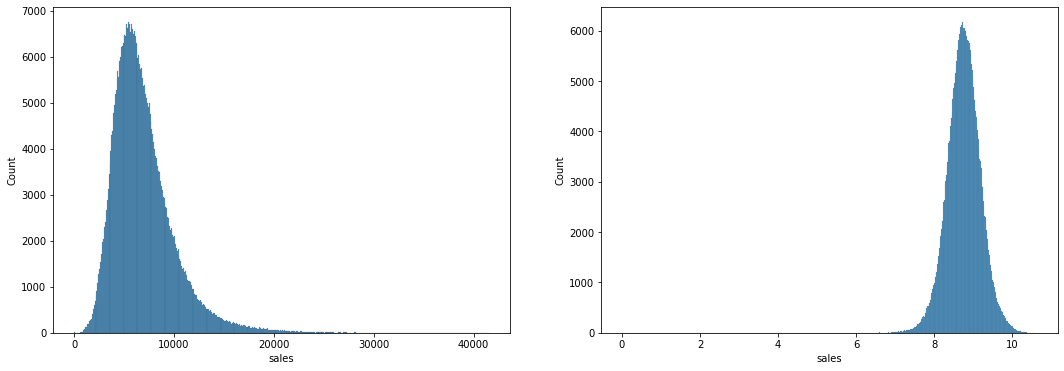

In [9]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.histplot(dados['sales'])

plt.subplot(1,2,2)
sns.histplot(np.log1p(dados['sales']))

plt.show()

Agora se assemelha mais com uma curva normal!

## 3.4 Pipeline

In [ ]:
# Unindo todos os preprocessing, temos um pipeline final:
pipe = Pipeline([('Target Encoder',te), 
                 ('Ordinal Encoder',oe), 
                 ('One Hot Encoder',ohe),
                 ('Drop Columns',dc),
                 ('Cyclic Encoder',ce),
                 ('Rescaling',scalers),
                 ('Estimator',TransformedTargetRegressor(regressor,func=np.log1p,inverse_func=np.expm1)) ])

In [10]:
# Quando eu faço o reescaling o dataframe vira um np array

# Essas são as colunas se eu precisar converter de array para dataframe
cols_names_pipeline = ['store', 'promo', 'state_holiday_public holiday',
       'state_holiday_Christmas', 'state_holiday_Easter holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_year', 'promo2', 'promo2_since_year',
       'promo_interval', 'year', 'week_bin', 'competition_lifetime',
       'competition', 'promo2_lifetime', 'promo_count_per_week', 'promo_n',
       'day_of_week_sin', 'day_of_week_cos',
       'competition_open_since_month_sin', 'competition_open_since_month_cos',
       'promo2_since_week_sin', 'promo2_since_week_cos', 'day_sin', 'day_cos',
       'month_sin', 'month_cos', 'week_sin', 'week_cos', 'quarter_sin',
       'quarter_cos', 'semester_sin', 'semester_cos', 'season_sin','season_cos']

## 3.5 No Pipeline

### 3.5.1 Data Split

In [11]:
dados['date'] = pd.to_datetime(dados['date'])

# Dividir entre train_val e test 
# (Para evitar overfit na Time Series, vou separar as 6 últimas semanas para test e o resto para train_val)
dados = dados.sort_values('date').reset_index(drop=True) # Sort by date
train_val = dados[dados['date']<dados['date'].max()-datetime.timedelta(6*7)] # Semanas Anteriores
test = dados[dados['date']>=dados['date'].max()-datetime.timedelta(6*7)] # 6 Últimas Semanas

# Dividir entre x e y
x_train_val = train_val.drop('sales',1)
y_train_val = train_val['sales']
x_test = test.drop('sales',1)
y_test = test['sales']

### Exporting Train_Val and Test

In [14]:
train_val.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/train_val2.csv',index=False)
test.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/test2.csv',index=False)

x_train_val.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_train_val2.csv',index=False)
y_train_val.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_train_val2.csv',index=False)
x_test.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_test2.csv',index=False)
y_test.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_test2.csv',index=False)

### 3.5.2 Processing Data

In [15]:
pipe = Pipeline([('Target Encoder',te), 
                 ('Ordinal Encoder',oe), 
                 ('One Hot Encoder',ohe),
                 ('Drop Columns',dc),
                 ('Cyclic Encoder',ce),
                 ('Rescaling',scalers)])

x_train_val_preprocessed = pipe.fit_transform(x_train_val,y_train_val)
y_train_val_preprocessed = np.log1p(y_train_val).ravel()
x_test_preprocessed = pipe.transform(x_test)
y_test_preprocessed = np.log1p(y_test).ravel()

### Exporting Data Preprocessed Without Pipeline

In [22]:
pd.DataFrame(x_train_val_preprocessed,columns=cols_names_pipeline).to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_train_val_preprocessed2.csv',index=False)
pd.DataFrame(y_train_val_preprocessed,columns=['sales']).to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_train_val_preprocessed2.csv',index=False)

pd.DataFrame(x_test_preprocessed,columns=cols_names_pipeline).to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_test_preprocessed2.csv',index=False)
pd.DataFrame(y_test_preprocessed,columns=['sales']).to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_test_preprocessed2.csv',index=False)

# 4.0 Feature Selection

## Import Data

In [23]:
x_train_val_preprocessed = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_train_val_preprocessed2.csv')
y_train_val_preprocessed = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_train_val_preprocessed2.csv')
x_test_preprocessed = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_test_preprocessed2.csv')
y_test_preprocessed = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_test_preprocessed2.csv')

## 4.1 Boruta

In [216]:
boruta = BorutaPy(RandomForestRegressor(n_jobs=-1),n_estimators='auto',verbose=2,random_state=101)
boruta.fit(np.array(x_train_val_preprocessed),np.array(y_train_val_preprocessed['sales']))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	13 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	14 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	15 / 100
Confirmed: 	21
Tentative: 	1
Rejected: 	16
Iteration: 	16 / 100
Confirmed: 	21
Tentative: 	1
Reject

BorutaPy(estimator=RandomForestRegressor(n_estimators=66, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x1686CF440),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x1686CF440,
         verbose=2)

Escolheu 22 variáveis como mais importantes e rejeitou 16!

In [ ]:
# Vou criar um df usando para comparar com os outros feature selectors
df_aux_boruta = pd.DataFrame([cols_names_pipeline,boruta.ranking_]).T.rename(columns={0:'features',1:'importance_boruta'})

## 4.2 XGBoost (Embedded Method)

In [438]:
xgb = XGBRegressor(n_jobs=-1,random_state=101,objective='reg:squarederror',verbosity=0)
xgb.fit(np.array(x_train_val_preprocessed),np.array(y_train_val_preprocessed['sales']))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=101,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [ ]:
# Vou criar um df usando para comparar com os outros feature selectors
df_aux_xgb = pd.DataFrame([cols_names_pipeline,xgb.feature_importances_*100]).T.rename(columns={0:'features',1:'importance_xgb'}).sort_values('importance_xgb',ascending=False).reset_index(drop=True)

## 4.3 Random Forest (Embedded Method)

In [425]:
rf = RandomForestRegressor(n_jobs=-1,random_state=101,verbose=0)
rf.fit(np.array(x_train_val_preprocessed),np.array(y_train_val_preprocessed['sales']))

RandomForestRegressor(n_jobs=-1, random_state=101)

In [ ]:
# Vou criar um df usando para comparar com os outros feature selectors
df_aux_rf = pd.DataFrame([cols_names_pipeline,rf.feature_importances_*100]).T.rename(columns={0:'features',1:'importance_rf'}).sort_values('importance_rf',ascending=False).reset_index(drop=True)

## 4.4 EDA 

In [427]:
# Pontuei, na EDA, de forma bastante conservadora as features que via grande possibilidade de impacto no modelo

# Vou criar um df para comparar com os outros feature selectors
columns_selected_eda = ['day_of_week_sin','day_of_week_cos', 'store_type', 'assortment', 'promo', 'promo_n', 'promo2', 'promo_interval', 'day_sin','day_cos']
columns_not_selected_eda = ['competition','competition_distance','competition_lifetime','competition_open_since_month_cos','competition_open_since_month_sin','competition_open_since_year','month_cos','month_sin','promo2_lifetime','promo2_since_week_cos','promo2_since_week_sin','promo2_since_year','promo_count_per_week','quarter_cos','quarter_sin','school_holiday','season_cos','season_sin','semester_cos','semester_sin','state_holiday_Christmas','state_holiday_Easterholiday','state_holiday_publicholiday','store','week_bin','week_cos','week_sin','year']
df_aux_eda = pd.DataFrame([columns_selected_eda+columns_not_selected_eda,[1,1,1,1,1,1,1,1,1,1]]).T.rename(columns={0:'features',1:'importance_eda'}).fillna(0)

## 4.4 Select Features

### 4.4.1 Compare the Results

In [428]:
# Merge results

df_aux = pd.merge(df_aux_boruta,df_aux_xgb,on='features')
df_aux = pd.merge(df_aux,df_aux_rf,on='features')
df_aux = pd.merge(df_aux,df_aux_eda,on='features')

df_aux = df_aux.sort_values('importance_xgb',ascending=False).reset_index(drop=True).set_index('features').rename_axis('')
df_aux

,importance_boruta,importance_xgb,importance_rf,importance_eda
,,,,
school_holiday,1,18.540432,9.540684,0
promo2_lifetime,1,6.199248,1.813789,0
month_sin,1,6.093179,3.014034,0
day_cos,1,4.999087,4.750319,1
promo2_since_year,1,4.997236,3.633218,0
day_sin,1,4.982315,18.107541,1
year,1,4.783257,2.073461,0
promo,1,4.746778,4.383147,1
promo_interval,1,4.408263,2.093293,1


### 4.4.2 Choose Features

In [25]:
cols_selected = ['school_holiday',
 'day_sin','day_cos','month_sin','month_cos','year',
 'promo','promo_interval',
 'store','assortment','store_type',
 'promo_n','promo2','promo2_lifetime']

### 4.4.3 Pipeline

In [4]:
# Adicionando feature selection no nosso pipeline!


# Target Encoding
te = TargetEncoder(cols=['store_type','promo_interval'],return_df=True)

# Ordinal Encoding
oe = OrdinalEncoder(cols=['assortment','season'],mapping=[{'col': 'assortment', 'mapping': {'basic': 0, 'extended': 1, 'extra': 2}},{'col': 'season', 'mapping': {'winter': 0, 'spring': 1, 'summer': 2,'autumn':3}}])

# One Hot Encoding
ohe = OneHotEncoder(cols=['state_holiday'],return_df=True,use_cat_names=True)

# Cyclic Encoding
class CyclicTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, n):
        self.cols = cols
        self.n = n
        
    def fit(self, X, y=None):
        return self 

    def transform(self, X, y = None):
        n_cols = len(self.cols)
        
        for c in range(n_cols):
            X[self.cols[c]+'_sin'] = X[self.cols[c]].apply(lambda x: np.sin(2*np.pi*x/self.n[c]))
            X[self.cols[c]+'_cos'] = X[self.cols[c]].apply(lambda x: np.cos(2*np.pi*x/self.n[c]))
            X.drop(self.cols[c],axis=1,inplace=True)
        return X
    
ce = CyclicTransformer(['day_of_week','competition_open_since_month', 'promo2_since_week', 'day', 'month', 'week', 'quarter', 'semester', 'season'],[7,12,52,30,12,52,4,2,4])



# Feature Selection
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self,cols_selected):
        self.cols_selected = cols_selected
        
    def fit(self, X, y=None):
        return self 

    def transform(self,X,y=None):
        return X[self.cols_selected]
    
fs = FeatureSelection(['school_holiday','day_sin','day_cos','month_sin','month_cos','year','promo','promo_interval','store','assortment','store_type','promo_n','promo2','promo2_lifetime']) # cols_selected



# Min Max Scaler Features
mms_columns_lst = ['store','store_type','assortment', 'promo_n', 'year','promo_interval', 'day_sin','day_cos', 'month_sin','month_cos',]

# Robust Scaler Features
rs_columns_lst = ['promo2_lifetime']

# Rescaling
scalers = make_column_transformer( (MinMaxScaler(), mms_columns_lst), (RobustScaler(), rs_columns_lst), remainder='passthrough' )



# Target Transformer
# I'll make a log transformation because the target has a positive skew



# Pipeline
pipe = Pipeline([('Target Encoder',te), 
                 ('Ordinal Encoder',oe), 
                 ('One Hot Encoder',ohe),
                 ('Cyclic Encoder',ce),
                 ('Feature Selection',fs),
                 ('Rescaling',scalers),
                 ('Estimator',TransformedTargetRegressor(regressor,func=np.log1p,inverse_func=np.expm1)) ])

# Quando eu faço o reescaling o dataframe vira um np array
# Essas são as colunas se eu precisar converter de array para dataframe
cols_names_pipeline = ['school_holiday','day_sin','day_cos','month_sin','month_cos','year','promo','promo_interval','store','assortment','store_type','promo_n','promo2','promo2_lifetime']

# 5.0 Machine Learning

## Import Datasets (Train_Val and Test)

In [31]:
x_train_val = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_train_val2.csv')
y_train_val = np.ravel(pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_train_val2.csv'))
x_test = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/x_test2.csv')
y_test = np.ravel(pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/y_test2.csv'))

train_val = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/train_val2.csv')
test = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/test2.csv')

In [29]:
# Regression report using cross_validation in timeseries

def reg_cv(regressor):
    
    # Target Encoding
    te = TargetEncoder(cols=['store_type','promo_interval'],return_df=True)

    # Ordinal Encoding
    oe = OrdinalEncoder(cols=['assortment','season'],mapping=[{'col': 'assortment', 'mapping': {'basic': 0, 'extended': 1, 'extra': 2}},{'col': 'season', 'mapping': {'winter': 0, 'spring': 1, 'summer': 2,'autumn':3}}])

    # One Hot Encoding
    ohe = OneHotEncoder(cols=['state_holiday'],return_df=True,use_cat_names=True)

    # Cyclic Encoding
    class CyclicTransformer(BaseEstimator, TransformerMixin):
        def __init__(self, cols, n):
            self.cols = cols
            self.n = n

        def fit(self, X, y=None):
            return self 

        def transform(self, X, y = None):
            n_cols = len(self.cols)

            for c in range(n_cols):
                X[self.cols[c]+'_sin'] = X[self.cols[c]].apply(lambda x: np.sin(2*np.pi*x/self.n[c]))
                X[self.cols[c]+'_cos'] = X[self.cols[c]].apply(lambda x: np.cos(2*np.pi*x/self.n[c]))
                X.drop(self.cols[c],axis=1,inplace=True)
            return X

    ce = CyclicTransformer(['day_of_week','competition_open_since_month', 'promo2_since_week', 'day', 'month', 'week', 'quarter', 'semester', 'season'],[7,12,52,30,12,52,4,2,4])



    # Feature Selection
    class FeatureSelection(BaseEstimator, TransformerMixin):
        def __init__(self,cols_selected):
            self.cols_selected = cols_selected

        def fit(self, X, y=None):
            return self 

        def transform(self,X,y=None):
            return X[self.cols_selected]

    fs = FeatureSelection(['school_holiday','day_sin','day_cos','month_sin','month_cos','year','promo','promo_interval','store','assortment','store_type','promo_n','promo2','promo2_lifetime']) # cols_selected



    # Min Max Scaler Features
    mms_columns_lst = ['store','store_type','assortment', 'promo_n', 'year','promo_interval', 'day_sin','day_cos', 'month_sin','month_cos',]

    # Robust Scaler Features
    rs_columns_lst = ['promo2_lifetime']

    # Rescaling
    scalers = make_column_transformer( (MinMaxScaler(), mms_columns_lst), (RobustScaler(), rs_columns_lst), remainder='passthrough' )



    # Target Transformer
    # I'll make a log transformation because the target has a positive skew
    
    # Pipeline
    estimator = Pipeline([('Target Encoder',te), 
                 ('Ordinal Encoder',oe), 
                 ('One Hot Encoder',ohe),
                 ('Cyclic Encoder',ce),
                 ('Feature Selection',fs),
                 ('Rescaling',scalers),
                 ('Estimator',TransformedTargetRegressor(regressor,func=np.log1p,inverse_func=np.expm1)) ])
    
    # Metrics
    neg_rmse = (cross_val_score(estimator,x_train_val,y_train_val,n_jobs=-1,cv=TimeSeriesSplit(n_splits=5),scoring='neg_root_mean_squared_error'))
    neg_mae = cross_val_score(estimator,x_train_val,y_train_val,n_jobs=-1,cv=TimeSeriesSplit(n_splits=5),scoring='neg_mean_absolute_error')
    neg_mape = cross_val_score(estimator,x_train_val,y_train_val,n_jobs=-1,cv=TimeSeriesSplit(n_splits=5),scoring='neg_mean_absolute_percentage_error')
    
    mean_rmse = round(neg_rmse.mean(),3)
    std_rmse = round(neg_rmse.std(),3)
    
    mean_mae = round(neg_mae.mean(),3)
    std_mae = round(neg_mae.std(),3)
    
    mean_mape = round(neg_mape.mean(),3)
    std_mape = round(neg_mape.std(),3)
    
    return print( tabulate( [ ['RMSE','MAE','MAPE'],[f'{mean_rmse} +/- ({std_rmse})',f'{mean_mae} +/- ({std_mae})',f'{mean_mape} +/- ({std_mape})'] ] ) )

## 5.1 Baseline Model (Average)

In [37]:
# Predict (get the average) of each store sales on train_val set
sales_average_by_store = train_val.groupby('store').mean()['sales']

# Merge (to compare) the predictions with real values in test set
df_merge = pd.merge(test,sales_average_by_store,on='store',suffixes=('_true','_pred')) 

# Get these values
y_true = df_merge['sales_true']
y_pred = df_merge['sales_pred']

# Analyse the Metrics

rmse = np.sqrt(mean_squared_error(y_true,y_pred))
mae = mean_absolute_error(y_true,y_pred)
mape = mean_absolute_percentage_error(y_true,y_pred)

print( tabulate( [ ['RMSE','MAE','MAPE'],[-rmse,-mae,-mape] ] ) )

-------------------  -------------------  --------------------
RMSE                 MAE                  MAPE
-1925.2426429675047  -1440.4935132907715  -0.22793976952687098
-------------------  -------------------  --------------------


Esse resultado será nossa base de comparação para os modelos de ML.

## 5.2 Linear Regression

In [36]:
reg_cv(LinearRegression())

-----------------------  ----------------------  --------------------------------------------
RMSE                     MAE                     MAPE
-2909.288 +/- (192.498)  -2011.857 +/- (98.949)  -1416664125584418.5 +/- (1009398359422529.8)
-----------------------  ----------------------  --------------------------------------------


Ok, esse resultado foi pior que o modelo baseline, então precisamos de modelos mais complexos!

## 5.3 Lasso

In [45]:
reg_cv(Lasso())

-----------------------  ----------------------  --------------------------------------------
RMSE                     MAE                     MAPE
-3236.966 +/- (156.744)  -2264.383 +/- (88.958)  -1412765187748512.5 +/- (1013101341393720.1)
-----------------------  ----------------------  --------------------------------------------


Esse resultado confirma a informação levantada na linear regression!

## 5.4 Decision Tree

In [56]:
reg_cv(DecisionTreeRegressor())

-----------------------  -----------------------  --------------------------------------------
RMSE                     MAE                      MAPE
-2512.459 +/- (267.368)  -1662.506 +/- (153.622)  -1454974923648267.5 +/- (1192321765511051.0)
-----------------------  -----------------------  --------------------------------------------


## 5.5 Random Forest Regressor

In [46]:
reg_cv(RandomForestRegressor(n_jobs=-1,random_state=101))

-----------------------  ----------------------  --------------------------------------------
RMSE                     MAE                     MAPE
-1934.633 +/- (241.191)  -1283.238 +/- (137.34)  -1559444921290254.5 +/- (1188742431680016.2)
-----------------------  ----------------------  --------------------------------------------


## 5.6 Neural Networks

In [54]:
reg_cv(MLPRegressor(solver='adam'))

-----------------------  -----------------------  -------------------------------------------
RMSE                     MAE                      MAPE
-3232.738 +/- (638.116)  -2436.503 +/- (664.719)  -1475107001272447.0 +/- (909918703168744.4)
-----------------------  -----------------------  -------------------------------------------


## 5.7 XGBoost Regressor

In [47]:
reg_cv(XGBRegressor(n_jobs=-1,random_state=101,objective='reg:squarederror'))

-----------------------  -----------------------  --------------------------------------------
RMSE                     MAE                      MAPE
-1857.364 +/- (230.168)  -1282.635 +/- (117.398)  -1404970464469688.5 +/- (1180038744378500.5)
-----------------------  -----------------------  --------------------------------------------


Até agora o melhor algoritmo seria o XGBoost, pelo menor tempo de execução, menor erro, menor variação e por ser mais leve, já pensando no deploy!

Vamos, então, fazer o hyperparameter fine tuning nele!

# 6.0 Hyperparameter Fine Tuning

## 6.1 Bayesian Search

In [75]:
pipe = Pipeline([('Target Encoder',te), 
             ('Ordinal Encoder',oe), 
             ('One Hot Encoder',ohe),
             ('Cyclic Encoder',ce),
             ('Feature Selection',fs),
             ('Rescaling',scalers),
             ('Estimator',TransformedTargetRegressor(XGBRegressor(n_jobs=-1,random_state=101,objective='reg:squarederror'),func=np.log1p,inverse_func=np.expm1)) ])

p_grid = dict()
p_grid['Estimator__regressor__n_estimators'] = [100,300,500,800,1000]
p_grid['Estimator__regressor__max_depth'] = [2,4,6,8,10,12]
p_grid['Estimator__regressor__learning_rate'] = [0.01,0.05,0.1,0.15,0.2,0.25,0.3]
p_grid['Estimator__regressor__subsample'] = [0.3,0.5,0.7,0.9,1]
p_grid['Estimator__regressor__gamma'] = [0,2,4,6,8,10]

search = BayesSearchCV(pipe,search_spaces=p_grid,n_jobs=-1,scoring='neg_root_mean_squared_error',cv=TimeSeriesSplit(n_splits=5),random_state=101,verbose=2)

In [76]:
search.fit(x_train_val,y_train_val)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END Estimator__regressor__gamma=6, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=800, Estimator__regressor__subsample=0.7; total time= 4.1min
[CV] END Estimator__regressor__gamma=0, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=2, Estimator__regressor__n_estimators=500, Estimator__regressor__subsample=0.3; total time=  28.7s
[CV] END Estimator__regressor__gamma=8, Estimator__regressor__learning_rate=0.05, Estimator__regressor__max_depth=4, Estimator__regressor__n_estimators=100, Estimator__regressor__subsample=0.9; total time=  19.2s
[CV] E

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.25, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 2.1min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.2, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 1.5min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.25, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 2.2min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.25, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 2.3min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.25, Estimator__regressor__max_depth=6, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=1.0; total time=  55.4s
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.2, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 1.8min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.25, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 1.8min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.25, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 2.0min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.25, Estim

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 2.2min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=100, Estimator__regressor__subsample=0.7; total time=  42.0s
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 1.5min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 1.8min
[CV] END Estimator__regres

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=Pipeline(steps=[('Target Encoder',
                                         TargetEncoder(cols=['store_type',
                                                             'promo_interval'])),
                                        ('Ordinal Encoder',
                                         OrdinalEncoder(cols=['assortment',
                                                              'season'],
                                                        mapping=[{'col': 'assortment',
                                                                  'mapping': {'basic': 0,
                                                                              'extended': 1,
                                                                              'extra': 2}},
                                                                 {'col': 'season',
                                        

[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 1.9min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 2.2min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 2.3min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 2.2min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_es

[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 3.6min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=12, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 2.6min
[CV] END Estimator__regressor__gamma=2, Estimator__regressor__learning_rate=0.15, Estimator__regressor__max_depth=10, Estimator__regressor__n_estimators=300, Estimator__regressor__subsample=0.7; total time= 3.9min


In [80]:
# See the results
pd.DataFrame(search.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Estimator__regressor__gamma,param_Estimator__regressor__learning_rate,param_Estimator__regressor__max_depth,param_Estimator__regressor__n_estimators,param_Estimator__regressor__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,113.732021,16.080227,1.651666,0.375968,2,0.15,10,300,0.7,"{'Estimator__regressor__gamma': 2, 'Estimator_...",-1698.091506,-2223.321215,-1637.536786,-1579.123755,-1612.885205,-1750.191693,239.739197,1
25,119.708186,15.728706,1.666848,0.372789,2,0.15,10,300,0.7,"{'Estimator__regressor__gamma': 2, 'Estimator_...",-1698.091506,-2223.321215,-1637.536786,-1579.123755,-1612.885205,-1750.191693,239.739197,1
26,127.725610,14.013248,1.669767,0.384396,2,0.15,10,300,0.7,"{'Estimator__regressor__gamma': 2, 'Estimator_...",-1698.091506,-2223.321215,-1637.536786,-1579.123755,-1612.885205,-1750.191693,239.739197,1
27,113.657988,16.207162,1.686510,0.357004,2,0.15,10,300,0.7,"{'Estimator__regressor__gamma': 2, 'Estimator_...",-1698.091506,-2223.321215,-1637.536786,-1579.123755,-1612.885205,-1750.191693,239.739197,1
28,116.516311,16.409341,1.694027,0.392662,2,0.15,10,300,0.7,"{'Estimator__regressor__gamma': 2, 'Estimator_...",-1698.091506,-2223.321215,-1637.536786,-1579.123755,-1612.885205,-1750.191693,239.739197,1
29,114.702099,16.469704,1.749561,0.414339,2,0.15,10,300,0.7,"{'Estimator__regressor__gamma': 2, 'Estimator_...",-1698.091506,-2223.321215,-1637.536786,-1579.123755,-1612.885205,-1750.191693,239.739197,1
30,115.516560,16.246948,1.695483,0.403593,2,0.15,10,300,0.7,"{'Estimator__regressor__gamma': 2, 'Estimator_...",-1698.091506,-2223.321215,-1637.536786,-1579.123755,-1612.885205,-1750.191693,239.739197,1
31,115.328757,16.633579,1.716961,0.392104,2,0.15,10,300,0.7,"{'Estimator__regressor__gamma': 2, 'Estimator_...",-1698.091506,-2223.321215,-1637.536786,-1579.123755,-1612.885205,-1750.191693,239.739197,1
33,117.012873,16.812946,1.699879,0.396346,2,0.15,10,300,0.7,"{'Estimator__regressor__gamma': 2, 'Estimator_...",-1698.091506,-2223.321215,-1637.536786,-1579.123755,-1612.885205,-1750.191693,239.739197,1
34,114.851902,16.041067,1.729672,0.399946,2,0.15,10,300,0.7,"{'Estimator__regressor__gamma': 2, 'Estimator_...",-1698.091506,-2223.321215,-1637.536786,-1579.123755,-1612.885205,-1750.191693,239.739197,1


## 6.2 Model Evaluation

In [83]:
# I'll use only a test set, im not doing any kind of cv for now

estimator = search.best_estimator_

y_pred = estimator.predict(x_test)
y_true = y_test

rmse = np.sqrt(mean_squared_error(y_true,y_pred)) 
mae = mean_absolute_error(y_true,y_pred)
mape = mean_absolute_percentage_error(y_true,y_pred)

print( tabulate( [ ['RMSE','MAE','MAPE'],[rmse,mae,mape] ] ) )

------------------  -----------------  -------------------
RMSE                MAE                MAPE
1413.2796671139372  979.0269988723503  0.14657659197467374
------------------  -----------------  -------------------


# 7.0 Error Interpretation

## 7.1 Business Performace

### 7.1.1 Our model predictions

In [204]:
estimator = search.best_estimator_

In [220]:
# Scenarios do nosso modelo (por loja)

sales_pred = pd.Series(estimator.predict(x_test),name='sales_pred')
sales_true = pd.Series(y_test,name='sales_true')
stores = x_test['store']
df_aux = pd.concat([stores,sales_true,sales_pred],axis=1)

df_aux['best_scenario'] = round(df_aux['sales_pred']+mean_absolute_error(df_aux['sales_true'],df_aux['sales_pred']),0)
df_aux['worst_scenario'] = round(df_aux['sales_pred']-mean_absolute_error(df_aux['sales_true'],df_aux['sales_pred']),0)
df_aux['error'] = round(df_aux['sales_true'] - df_aux['sales_pred'],0)

df_aux = df_aux.groupby('store').sum()

df_aux

,sales_true,sales_pred,best_scenario,worst_scenario,error
store,,,,,
1,54903,53955.984375,65705.0,42209.0,946.0
2,66017,60451.914062,74159.0,46747.0,5564.0
3,151429,147361.468750,169878.0,124844.0,4068.0
4,202317,192558.718750,212138.0,172977.0,9760.0
5,66224,66852.671875,81538.0,52168.0,-629.0
...,...,...,...,...,...
1111,98788,99948.664062,119532.0,80369.0,-1163.0
1112,185681,190096.640625,210657.0,169537.0,-4416.0
1113,152514,154563.484375,177080.0,132045.0,-2049.0


In [221]:
# Confiança dos scenarios do nosso modelo (por loja)

df_aux['worst_scenario_error'] = df_aux['sales_true'] - df_aux['worst_scenario'] 
df_aux['best_scenario_error'] = df_aux['sales_true'] - df_aux['best_scenario'] 

best_scenario_superestima_media = round(df_aux[df_aux['best_scenario_error']<0]['best_scenario_error'].mean(),1)
best_scenario_superestima_std = round(df_aux[df_aux['best_scenario_error']<0]['best_scenario_error'].std(),1)
show_best_scenario_superestima = f'{best_scenario_superestima_media} +/- ({best_scenario_superestima_std})'

best_scenario_subestima_media = round(df_aux[df_aux['best_scenario_error']>0]['best_scenario_error'].mean(),1)
best_scenario_subestima_std = round(df_aux[df_aux['best_scenario_error']>0]['best_scenario_error'].std(),1)
show_best_scenario_subestima = f'{best_scenario_subestima_media} +/- ({best_scenario_subestima_std})'

worst_scenario_superestima_media = round(df_aux[df_aux['worst_scenario_error']<0]['worst_scenario_error'].mean(),1)
worst_scenario_superestima_std = round(df_aux[df_aux['worst_scenario_error']<0]['worst_scenario_error'].std(),1)
show_worst_scenario_superstima = f'{worst_scenario_superestima_media} +/- ({worst_scenario_superestima_std})'

worst_scenario_subestima_media = round(df_aux[df_aux['worst_scenario_error']>0]['worst_scenario_error'].mean(),1)
worst_scenario_subestima_std = round(df_aux[df_aux['worst_scenario_error']>0]['worst_scenario_error'].std(),1)
show_worst_scenario_subestima = f'{worst_scenario_subestima_media} +/- ({worst_scenario_subestima_std})'

tab = [ ['Scenario','Superestima','Subestima'],['Best',show_best_scenario_superestima,show_best_scenario_subestima],['Worst',show_worst_scenario_superstima,show_worst_scenario_subestima] ]
print(tabulate(tab,headers='firstrow'))

Scenario    Superestima            Subestima
----------  ---------------------  ---------------------
Best        -17580.8 +/- (9111.2)  11788.0 +/- (14350.1)
Worst       -4480.8 +/- (3889.6)   22957.3 +/- (13582.7)


### 7.1.2 Compare these predictions with the baseline model

In [222]:
# Erro (por loja) (MAE e MAPE) do nosso modelo

y_true = df_aux['sales_true']
y_pred = df_aux['sales_pred']

print('MAE: {}'.format(round(mean_absolute_error(y_true,y_pred),1)))
print('MAPE: {}'.format(round(mean_absolute_percentage_error(y_true,y_pred)*100,2)))

MAE: 9630.7
MAPE: 7.06


In [223]:
# Erro (por loja) (MAE e MAPE) do modelo baseline

pred = train_val.groupby('store').mean()['sales'].reset_index().rename(columns={'sales':'sales_pred'})
true = test[['store','sales']].rename(columns={'sales':'sales_true'})
df_aux_baseline = pd.merge(true,pred,on='store')
df_aux_baseline = df_aux_baseline.groupby('store').sum()

y_true = df_aux_baseline['sales_true']
y_pred = df_aux_baseline['sales_pred']

print('MAE: {}'.format(round(mean_absolute_error(y_true,y_pred),1)))
print('MAPE: {}'.format(round(mean_absolute_percentage_error(y_true,y_pred)*100,2)))

MAE: 8984.9
MAPE: 7.08


## 7.2 Análise de Resíduo

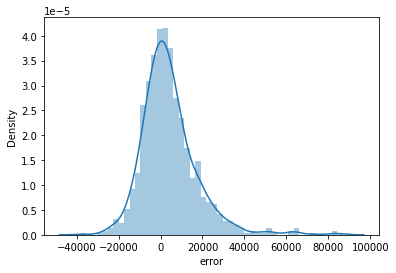

In [178]:
# Distribuição do resíduo
sns.distplot(df_aux['error']);

Segue uma distribuição parecida com a normal, o que é ótimo.

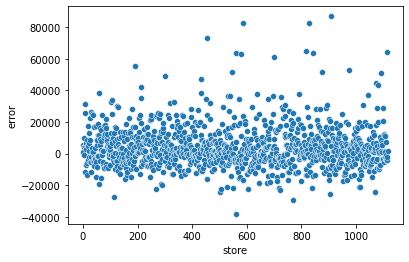

In [181]:
# Scatter dos erros
sns.scatterplot(df_aux.index,df_aux['error']);

Segue a distribuição esperada. Vemos alguns outliers, mas o comportamento geral é aquele essencial.

In [ ]:
# checkpoint

# 8.0 Deploy Model in Production

## 8.1 Export Model

In [74]:
# Vamos exportar nosso modelo final que irá ser colocado em produção
cols_selected = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'promo_interval',
 'competition_lifetime',
 'promo2_lifetime',
 'promo_n',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'sales']

x = dados[cols_selected].drop('sales',1)
y = dados[cols_selected]['sales']

model = XGBRegressor(n_jobs=-1,random_state=101,objective='reg:squarederror').fit(x,y) # train with the whole dataset
pickle.dump(model,open('/Users/nando/Comunidade DS/ds_em_producao/deploy/model.pickle','wb'))

## 8.2 Data Modeling and Predict Class

In [262]:
# Vamos criar uma classe que contenha todos os passos que modelam e preparam os dados para o algoritmo entender

import pandas as pd
import numpy as np
import inflection
import datetime
import pickle

initial_data = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/inital_data.csv') # i will use later

class rossmann(object):
    
    def __init__(self):
        self.store_type_label_encoder = pickle.load(open('/Users/nando/Comunidade DS/ds_em_producao/deploy/local_deploy/store_type_label_encoder.pickle','rb'))
        self.promo_interval_target_encoder = pickle.load(open('/Users/nando/Comunidade DS/ds_em_producao/deploy/local_deploy/promo_interval_target_encoder.pickle','rb'))
        self.min_max_scaler = pickle.load(open('/Users/nando/Comunidade DS/ds_em_producao/deploy/local_deploy/min_max_scaler.pickle','rb'))
        self.robust_scaler = pickle.load(open('/Users/nando/Comunidade DS/ds_em_producao/deploy/local_deploy/robust_scaler.pickle','rb'))

    def data_cleaning(self,dados):
        ## 1.1 Rename Columns and Values

        # CamelCase to snake_case
        for c in range(len(dados.columns)):
            dados.rename(columns={dados.columns.values[c]:inflection.underscore(dados.columns.values[c])},inplace=True)

        dados['state_holiday'] = dados['state_holiday'].map({'a':'public holiday', 'b':'Easter holiday', 'c':'Christmas', '0':'None'})
        dados['assortment'] = dados['assortment'].map({'a':'basic','b':'extra','c':'extended'})

        ## 1.3 Data Types

        # date to datetime64
        dados['date'] = pd.to_datetime(dados['date'])

        ### 1.4 Dealing With NAN

        ## competition_distance, competition_open_since_month, competition_open_since_year
        # I suppose that the competition_distance == nan refers that there's no competition!
        for index in dados[dados['competition_distance'].isna()].index:
            dados.loc[index,'competition_distance'] = 999999 # High values suggests that the competitors are so far that there's no competition
            dados.loc[index,'competition_open_since_month'] = 0 # It suggets that it has never been opened
            dados.loc[index,'competition_open_since_year'] = 0 # It suggets that it has never been opened

        ## competition_open_since_month, competition_open_since_year
        # I suppose that if there's no year, there's no month and vice-versa
        month_median = round(initial_data['CompetitionOpenSinceMonth'].median(),0) # get the median of the whole dataset
        year_median = round(initial_data['CompetitionOpenSinceYear'].median(),0) # get the median of the whole dataset
        for index in dados[dados['competition_open_since_month'].isna()].index:
            dados.loc[index,'competition_open_since_month'] = month_median # Im gonna use median and round to have discret values
            dados.loc[index,'competition_open_since_year'] = year_median # Im gonna use median and round to have discret values

        ## promo_interval, promo2_since_week, promo2_since_year
        # Because if there's no promo2, theres no since date or interval
        for index in dados[dados['promo2_since_week'].isna()].index:
            dados.loc[index, 'promo2_since_week'] = 0 # It suggets that there's no promo2 week start
            dados.loc[index, 'promo2_since_year'] = 0 # It suggets that there's no promo2 year start
            dados.loc[index, 'promo_interval'] = 'No promo2' # For now, im going to substitute with this

        ## 1.5 Data Types (after NaN)

        # float to int in columns related to dates
        dados['competition_open_since_month'] = dados['competition_open_since_month'].astype(int)
        dados['competition_open_since_year'] = dados['competition_open_since_year'].astype(int)
        dados['promo2_since_week'] = dados['promo2_since_week'].astype(int)
        dados['promo2_since_year'] = dados['promo2_since_year'].astype(int)
        
        return dados
    
    def feature_engineering(self,dados):
        # Day, Month, Week and Year Variables
        dados['day'] = pd.to_datetime(dados['date']).dt.day
        dados['month'] = pd.to_datetime(dados['date']).dt.month
        dados['year'] = pd.to_datetime(dados['date']).dt.year
        dados['week'] = pd.to_datetime(dados['date']).dt.week

        # Semester and Quarter
        dados['quarter'] = pd.to_datetime(dados['date']).dt.quarter
        dados['semester'] = pd.to_datetime(dados['date']).dt.quarter.apply(lambda x: 1 if x == 1 or x == 2 else 2)

        # Season
        def season_of_date(date):
            year = str(date.year)
            seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
                       'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
                       'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
            if date in seasons['spring']:
                return 'spring'
            if date in seasons['summer']:
                return 'summer'
            if date in seasons['autumn']:
                return 'autumn'
            else:
                return 'winter'
        dados['season'] = pd.to_datetime(dados['date']).map(season_of_date)

        # Weeks for timeseries analyses
        dados['week_bin'] = np.nan
        for index in dados.index:
            if dados.loc[index,'year']==2013:
                dados.loc[index,'week_bin'] = dados.loc[index,'week']
            if dados.loc[index,'year']==2014:
                dados.loc[index,'week_bin'] = dados.loc[index,'week'] + 52
            if dados.loc[index,'year']==2015:
                dados.loc[index,'week_bin'] = dados.loc[index,'week'] + 104
        dados['week_bin'] = dados['week_bin'].astype('int')

        # Competition Lifetime
        dados['competition_lifetime'] = np.nan
        for index in dados.index:
            try:
                data = datetime.datetime(dados.loc[index,'competition_open_since_year'],dados.loc[index,'competition_open_since_month'],1)
                dados.loc[index, 'competition_lifetime'] = (pd.to_datetime(dados.loc[index,'date']) - data).days

            except:
                dados.loc[index,'competition_lifetime'] = -999 # Never opened
        dados['competition_lifetime'] = dados['competition_lifetime'].astype('int')

        # Competition
        dados['competition'] = dados['competition_lifetime'].apply(lambda x: 0 if x<0 else 1) # Negative values suggests that this competition has never been started yet or we don't even have competitors (we chose -999 above)

        # Promo2 Lifetime
        dados['promo2_lifetime'] = np.nan
        for index in dados.index:
            if dados.loc[index,'promo_interval'] != 'No promo2':
                year = dados.loc[index,'promo2_since_year']
                week = dados.loc[index,'promo2_since_week']
                date = "{}-W{}".format(year,week)
                date_datetime = datetime.datetime.strptime(date + '-1', "%Y-W%W-%w")
                dados.loc[index,'promo2_lifetime'] = (pd.to_datetime(dados.loc[index,'date']) - date_datetime).days
            else:
                dados.loc[index,'promo2_lifetime'] = -999
        dados['promo2_lifetime'] = dados['promo2_lifetime'].astype(int)

        # Promo Count per Week
        dados['promo_count_per_week'] = np.nan
        for index in dados.index:
            week = dados.loc[index,'week_bin']
            store = dados.loc[index,'store']
            try:
                dados.loc[index,'promo_count_per_week'] = dados[dados['store']==store].groupby('week_bin').sum()['promo'][week]
            except:
                dados.loc[index,'promo_count_per_week'] = 0
        dados['promo_count_per_week'] = dados['promo_count_per_week'].astype('int')

        # Enumerate per week each store promotion
        dados['promo_n'] = np.nan
        for c in dados.index:
            if dados.loc[c,'promo_count_per_week']>0: # os que tem promoção na semana: Enumerate the promotion per store on each week
                week = dados.loc[c,'week_bin']
                store = dados.loc[c,'store']
                df_aux = pd.DataFrame(dados[(dados['store']==store)&(dados['week_bin']==week)].sort_values(by='date')['promo'])[dados['promo']==1].reset_index().reset_index().set_index('index')
                df_aux['level_0'] = df_aux['level_0'] + 1
                for index in df_aux.index:
                    dados.loc[index,'promo_n'] = df_aux.loc[index,'level_0']
            elif dados.loc[c,'promo_count_per_week']==0: # os que não tem promoção na semana: iguala a 0
                dados.loc[c,'promo_n'] = 0
        dados['promo_n'].fillna(-1,inplace=True) # São dias sem promoção em semanas com promoção: iguala a -1
        dados['promo_n'] = dados['promo_n'].astype('int')
        
        return dados
    
    def data_preprocessing(self,dados):
        ## 3.2 Encoding

        ## One Hot Encoding (state_holiday)
        dados['easter'] = dados['state_holiday'].apply(lambda x: 1 if x=='Easter holiday' else 0)
        dados['public_holiday'] = dados['state_holiday'].apply(lambda x: 1 if x=='public holiday' else 0)
        dados['christmas'] = dados['state_holiday'].apply(lambda x: 1 if x=='Christmas' else 0)
        dados.drop('state_holiday',1,inplace=True)

        ## Label Encoding (store_type)
        dados['store_type'] = self.store_type_label_encoder.transform(dados[['store_type']])

        ## Ordinal Encoding (assortment, season)
        dados['assortment'] = dados['assortment'].map({'basic':0,'extended':1,'extra':2})
        dados['season'] = dados['season'].map({'winter':1,'spring':2,'summer':3,'autumn':4})

        ## Target Encoding (promo_interval)
        dados['promo_interval'] = self.promo_interval_target_encoder.transform(dados['promo_interval'])

        ## Cyclic Encoding (day_of_week, competition_open_since_month, promo2_since_week, day, month, week, quarter, semester, season)
        dados['day_of_week_sin'] = dados['day_of_week'].apply(lambda x: np.sin(2*np.pi*x/7))
        dados['day_of_week_cos'] = dados['day_of_week'].apply(lambda x: np.cos(2*np.pi*x/7))
        dados.drop('day_of_week',1,inplace=True)

        dados['competition_open_since_month_sin'] = dados['competition_open_since_month'].apply(lambda x: np.sin(2*np.pi*x/12))
        dados['competition_open_since_month_cos'] = dados['competition_open_since_month'].apply(lambda x: np.cos(2*np.pi*x/12))
        dados.drop('competition_open_since_month',1,inplace=True)

        dados['promo2_since_week_sin'] = dados['promo2_since_week'].apply(lambda x: np.sin(2*np.pi*x/52))
        dados['promo2_since_week_cos'] = dados['promo2_since_week'].apply(lambda x: np.cos(2*np.pi*x/52))
        dados.drop('promo2_since_week',1,inplace=True)

        dados['day_sin'] = dados['day'].apply(lambda x: np.sin(2*np.pi*x/30))
        dados['day_cos'] = dados['day'].apply(lambda x: np.cos(2*np.pi*x/30))
        dados.drop('day',1,inplace=True)

        dados['month_sin'] = dados['month'].apply(lambda x: np.sin(2*np.pi*x/12))
        dados['month_cos'] = dados['month'].apply(lambda x: np.cos(2*np.pi*x/12))
        dados.drop('month',1,inplace=True)

        dados['week_sin'] = dados['week'].apply(lambda x: np.sin(2*np.pi*x/52))
        dados['week_cos'] = dados['week'].apply(lambda x: np.cos(2*np.pi*x/52))
        dados.drop('week',1,inplace=True)

        dados['quarter_sin'] = dados['quarter'].apply(lambda x: np.sin(2*np.pi*x/4))
        dados['quarter_cos'] = dados['quarter'].apply(lambda x: np.cos(2*np.pi*x/4))
        dados.drop('quarter',1,inplace=True)

        dados['semester_sin'] = dados['semester'].apply(lambda x: np.sin(2*np.pi*x/2))
        dados['semester_cos'] = dados['semester'].apply(lambda x: np.cos(2*np.pi*x/2))
        dados.drop('semester',1,inplace=True)

        dados['season_sin'] = dados['season'].apply(lambda x: np.sin(2*np.pi*x/4))
        dados['season_cos'] = dados['season'].apply(lambda x: np.cos(2*np.pi*x/4))
        dados.drop('season',1,inplace=True)

        ## 3.3 Rescaling

        ## Min Max Scaler (store,week_bin, promo_count_per_week, promo_n, year, store_type, assortment, promo_interval, day_of_week_sin/cos, competition_open_since_month_sin/cos, promo2_since_week_sin/cos, day_sin/cos, month_sin/cos, week_sin/cos, quarter_sin/cos, semester_sin/cos, season_sin/cos)

        mms_columns_lst = ['store','week_bin', 'promo_count_per_week', 'promo_n', 'year', 'store_type', 'assortment',
        'promo_interval', 'day_of_week_sin','day_of_week_cos', 'competition_open_since_month_sin',
        'competition_open_since_month_cos', 'promo2_since_week_sin','promo2_since_week_cos', 
        'day_sin','day_cos', 'month_sin','month_cos', 'week_sin','week_cos', 'quarter_sin',
        'quarter_cos', 'semester_sin','semester_cos', 'season_sin','season_cos']

        dados[mms_columns_lst] = self.min_max_scaler.transform(dados[mms_columns_lst])

        ## Robust Scaler (competition_distance, competition_open_since_year, promo2_since_year, competition_lifetime, promo2_lifetime)

        rs_columns_lst = ['competition_distance', 'competition_open_since_year', 'promo2_since_year',
                          'competition_lifetime', 'promo2_lifetime']

        dados[rs_columns_lst] = self.robust_scaler.transform(dados[rs_columns_lst])

        return dados
    
    def feature_selection(self,dados):
        cols_selected = ['store',
         'promo',
         'store_type',
         'assortment',
         'competition_distance',
         'promo_interval',
         'competition_lifetime',
         'promo2_lifetime',
         'promo_n',
         'day_of_week_sin',
         'day_of_week_cos',
         'day_sin',
         'day_cos',
         'month_sin',
         'month_cos']

        dados = dados[cols_selected]
        
        return dados
    
    def get_prediction( self, model, original_data, input_data ):
        
        pred = model.predict( input_data )
        
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' ) # return a df with the original imput and it's prediction

## 8.3 API Handler

In [291]:
# Vamos criar uma api com o flask para podermos acessar esse modelo de qualquer dispositivo que faça requests

from flask import Flask,request,Response
from Rossmann import rossmann
import pickle
import pandas as pd

pipeline = rossmann()        
model = pickle.load(open('/Users/nando/Comunidade DS/ds_em_producao/deploy/local_deploy/model.pickle', 'rb'))

app = Flask(__name__)

@app.route('/predict',methods=['POST'])
def predict():
    
    json = request.get_json() # Get the data
    
    if json: # Foram de fato passados dados
        if isinstance( json, dict ): # um único exemplo
            df_json = pd.DataFrame( json, index=[0] ) 
        else:
            df_json = pd.DataFrame( json, columns=json[0].keys() ) # múltiplos examplos
        
        # data modeling
        dados = df_json.copy()
        dados = pipeline.data_cleaning(dados)
        dados = pipeline.feature_engineering(dados)
        dados = pipeline.data_preprocessing(dados)
        dados = pipeline.feature_selection(dados)
        
        # predict
        dados_response = pipeline.get_prediction(model,df_json,dados)
        
        return dados_response # retorna um df com os dados sem modeling e a prediction sem modeling também
        
            
    else: # não foram passados os dados
        return Response('{}',status=200,mimetype='application/json') # retorna vazio
    
    
if __name__=='__main__':
    app.run(host='0.0.0.0',port=8080,debug=False)

ImportError: cannot import name 'rossmann' from 'Rossmann' (/Users/nando/Comunidade DS/ds_em_producao/Rossmann.py)

## 8.4 API Tester

In [ ]:
# Precisamos testar nossa API aqui para ver se está tudo funcionando corretamente

### 8.4.1 Get the input

In [12]:
# get the data (from data folder)
test_data = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/test.csv')
test_data = pd.merge(test_data,dados_stores,how='left',on='Store').drop('Id',1)

# choose the stores to predict
test_data = test_data[test_data['Store'].isin([30,22,101,200])]

# filter (o modelo não vai receber esses inputs quando estiver de fato em produção!)
test_data = test_data[test_data['Open']==1] # e eu pressuponho que o consumidor quer calcular vendas da loja enquanto aberta!
test_data.drop('Open',axis=1,inplace=True)

# convert to json (para comunicar com a api)
test_data = test_data.to_json(orient='records')

### 8.4.2 Local Test

In [7]:
import requests

url = 'http://0.0.0.0:8080/predict' # localhost
headers = {'Content-type': 'application/json' }
data = test_data # input

r = requests.post( url=url, data=data, headers=headers ) 
print( 'Status Code {}'.format( r.status_code ) ) # ver se deu certo

Status Code 200


In [8]:
pd.DataFrame(r.json()) # converter a response, que veio em forma de json

,Store,DayOfWeek,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,prediction
0,22,4,2015-09-17,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",5759.546875
1,30,4,2015-09-17,1,0,0,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec",4686.000000
2,101,4,2015-09-17,1,0,0,d,c,2440.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6491.229980
3,200,4,2015-09-17,1,0,0,a,a,1650.0,10.0,2000.0,0,NaN,NaN,None,7675.339355
4,22,3,2015-09-16,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",5759.546875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,200,1,2015-08-03,1,0,1,a,a,1650.0,10.0,2000.0,0,NaN,NaN,None,11290.367188
159,22,6,2015-08-01,0,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",3554.942383
160,30,6,2015-08-01,0,0,0,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec",4299.778809
161,101,6,2015-08-01,0,0,0,d,c,2440.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6973.650879


Everything working fine!

### 8.4.3 Cloud Test

In [10]:
import requests

url = 'https://rossmann-pm.herokuapp.com/predict' # heroku cloud
headers = {'Content-type': 'application/json' }
data = test_data # input

r = requests.post( url=url, data=data, headers=headers ) 
print( 'Status Code {}'.format( r.status_code ) ) # ver se deu certo

Status Code 200


In [11]:
pd.DataFrame(r.json()) # converter a response, que veio em forma de json

,Store,DayOfWeek,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,prediction
0,22,4,2015-09-17,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",5759.546875
1,30,4,2015-09-17,1,0,0,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec",4686.000000
2,101,4,2015-09-17,1,0,0,d,c,2440.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6491.229980
3,200,4,2015-09-17,1,0,0,a,a,1650.0,10.0,2000.0,0,NaN,NaN,None,7675.339355
4,22,3,2015-09-16,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",5759.546875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,200,1,2015-08-03,1,0,1,a,a,1650.0,10.0,2000.0,0,NaN,NaN,None,11290.367188
159,22,6,2015-08-01,0,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",3554.942383
160,30,6,2015-08-01,0,0,0,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec",4299.778809
161,101,6,2015-08-01,0,0,0,d,c,2440.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6973.650879


Está aí! Projeto finalizado com deploy na nuvem!

# Used Fonts

All About Missing Data Handling: https://towardsdatascience.com/all-about-missing-data-handling-b94b8b5d2184